# Running Throughput Tests on Prototype
## What you will need
    -test order file
    -sample tube (with bar codes matching the test order file)
    -appropriate racks for all of the tube
    -capabilities files for each of the 6 HCA simulators
    
## Running the Prototype
I created 6 instances of the appHCA folder numbered 1-6 as appHCA1, appHCA2, appHCA3...etc which each have their own individual capability.json file. I recommend using this because it enables you to test throughput with mixed capabilities. There should a version of the script file used to start the simulated HCAs which is already configured to enable this. If not it simply requires changing the path reference with each of the 6 blocks of code in the script (for each HCA) to point to the respective folders as described above.

To run an "experiment" simply program all of the samples you intend to run to receive the test profile you intend for them to receive, push racks of these samples through the system, grab the RTC canLog, unpack the log using the sips.dll (Smart Inspect DLL), and use this script to analyze the unpacked log. 

It is critical that you do the following: keep a record of what racks you entered into the system AND in what order, do not halt the system before it has completed its operations (the last rack in your batch has reach the end of the output lane), keep track of any racks that do not register (they are transferred to the presenter, go through the presenter, but do not get routed to an analyzer because the RackID cannot be deteremined), keep track of any racks that get hung up in the buffer.

essentially the issue is the systems logs are continuously generated for a given date SO if there are failures that occur or people run racks prior to you running throughput experiments that data will be in the canLog. One sure fire way to get around this and not have to use the complicated error handling routines I created in this program is to manually truncate the data file(s) so that minimally they start when YOU started running experiments. You don't technically have to clip the file to end after a given run because this program enables for searching for batches of racks within all racks that are detected within the file. In other words if you ran 3 experiments of 30 racks each the file would contain 90 detected racks. If you define the test vector to contain the 30 racks you did test for any given experiment it will parse for those 30 and extract the data for that particular experiment.

## Running this script
This script is divided into cells which are intended to individually perform key functions. The nature of this script as a Jupyter script enable the user to run individual sections of the program independent of others. The program is intended to be run in order and the safest way to run it is the "Restart Kernel and Run All Cells" option in the Run menu. This option restarts the kernel first which clears all varibles and memory and then runs the program. This is useful because it can clear conflicts or issues with overwrites to varibles done by any manual editting. 

I STRONGLY recommend that you read over the program and become familiar with the function/intent of each cell. There are several variables that need to be modified to execute the program successfully such as pointers to files and variables that instantiate the experiment within the program. These are clearly marked with a '##CHANGE REQUIRED##' comment next the variable. Be sure to change these before running the program.

The analysis is divided into two classes: Timing and Utilization. Timing analysis extracts the times when certain actions started using messages called commands (labeled as Cmd) and the times when the actions were completed using messages called responses (labeled as Rsp) to compute action time statistics and vectors which feed into the second class. Utilization analysis determines the percent of time that a module is utilized (per the charter this is designed to help identify bottlenecks by highlighiting when something is nearly constantly utilized for example).

In [1]:
## Import Libraries and Set Plotting Parameters
#import list imports the libraries necessary to run the program and modifies font and sizing parameters for figures generatd by the script

import pandas as pd
import scipy as sp
from scipy import stats
import time
import datetime
import numpy as np
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
import math
from pylab import *

#These parameters hard code aspects of the figures generated by the program. Modify them to modify the global settings else comment these out and individually modify the figures with their own code (not included)
matplotlib.rcParams['figure.figsize'] = (25, 15)
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

In [2]:
## Import data module 
#files converted from sil canLogs using powershell+script are imported as a dataframe.
#uses relative path referencing and pandas to import the data, pd.read_csv can accept .txt and .csv files so long as the delimiter is properly designated.
#some files have unmatched commands or other things that can cause problems with the analysis methods employed throughout the script variables (st, ed) are provided to manually crop the data file. See below

# 'throughput_pt.txt' 'tpt_nominal_2.txt' 'tpt_nominal_4_6.txt' 'canlogtest1.csv' 'tp_nominal_3.txt'

### File import
filename = 'tpt_aptt_pt_6.txt' #name of the file you intend to analyze ##CHANGE REQUIRED##
directory = 'canLogs/' #relative path reference ##CHANGE REQUIRED##
try:
    data = pd.read_csv(directory + filename, delimiter = ",")
    print(f"Successfully imported '{filename}'")
except:
    print("File Read Unsuccessful")
###

### Modify start as st and end as ed to crop the data file to remove unmatched commands 
# st = 0
# ed = len(data.Title) ##CHANGE REQUIRED##
# data = data[st:ed].reset_index(drop=True) #use this line to leverage the croping defined by st and ed
###

test_type = 'combo' #test profile, this string is appended to output files so ensure this is correct  ##CHANGE REQUIRED##
save_figs = False #binary; if true all generated figures are saved a .png files with names containing the test_type ##CHANGE REQUIRED##
save_summary = False #binary; if true the summary dataframe created by the program is saved to an output file ##CHANGE REQUIRED##

#early initialization of a summary dictionary used to summarize data which is exported to a summary file
#The way I use this in the program is that I assume there will be different parameters of interest. As an example lets say Time in Buffer. 
#For this parameter the value of interest may be the mean. In the dict summary there will be a key called "Time in Buffer" associated with a list 
#which contains as its 0th element the "Value" of interest for that parameter (key). Later I convert the dict to a DataFrame. In the function I say that the 0th element
#of every list associated with keys in the dict are the "Value" which means they the dict key is converted to the index (DataFrames handle numerical or string indexs) and
#and I assign a new key to these elements as "Value" '
#
#When modifying the summary first review the "keys" in the dict to df function call near the end of this script and modify this as needed. Note that adding to or removing from this list
#changes the expected number of elements in ech list within the "summary" dict. Also noting that if you change the keys in the dict to df function call you will have to make sure EVERY
#list is the appropriate length. You will see that I handle this by filling in lists with np.NaNs. I STRONGLY encourage whomever works on this in the future to modify this summary mechanism
#I did it this way because it is flexible but it requires a lot of labor to change. It may be better to use the xlsx writing capabilities of pandas to_excel function. To do this create dicts or DataFrames
#and use this function to add them to individual sheets

summary = {} 

colors = {'Distributor':'black', 'LS Track':'lightseagreen', 'Analyzer 1':'red', 'Analyzer 2':'orange', 'Analyzer 3':'green','Analyzer 4':'blue','Analyzer 5':'purple', 'Analyzer 6':'olive', 'Presenter':'gray'} #dictionary of colors used in graphs to standardize; see list of colors here: https://matplotlib.org/stable/gallery/color/named_colors.html

Successfully imported 'tpt_aptt_pt_6.txt'


In [3]:
## Datetime conversion and UnixTime generation
#the Stratec can log file contains time information in a date-time format
#in order to be able to determine differences between action timings the date-time is reformatted to epoch (unix) time. 
#This standardized timing scheme of time in seconds since a specified historical date means that the difference between two epoch times is the time in seconds between those two times (aka the time it takes for the SMM to complete a certain action)

### Variable Initialization
datetimes = data["Timestamp"]
unixtime = []
date = []
time = []
time_frame_indicator = []
epch_time = []
###

### Manipulate Data Time format native to log to produce a Unix Time
for i in datetimes:
    splits = i.split() #split string on spaces
    date_splits = splits[0].split("/") #split data on the /
    
    cntr2 = 0 #initialize a indexing counter
    
    #add leading 0 to month
    for j in date_splits:
        if len(j) < 2:
            date_splits[cntr2] = '0' + j
            cntr2 += 1
    date.append(date_splits[0] + '/' + date_splits[1] +'/' + date_splits[2])
    time.append('0' + splits[1])
    time_frame_indicator.append(splits[2])
     
data["Date"] = date #add new date format to df
data["Time"] = time #add new time format to df
data["TimeFrame"] = time_frame_indicator #add new AM/PM indicator to df

mod_datetime = data['Date'] + ' ' + data['Time'] + ' ' + data['TimeFrame'] #create concatinated date time for conversion to unix time
data['DateTime'] = mod_datetime #add new date-time to df
###

### Generate Unix Time
for k in data['DateTime']:
    t = datetime.datetime.strptime(k, '%m/%d/%Y %I:%M:%S %p')
    epch_time.append(t.timestamp()) #iteratively generate UnixTime (referred to as Epoch Time)

data["UnixTime"] = epch_time #add unix time to df
###

#Export modified data used in rest of script to csv file
data.to_csv(filename.split('.')[0]+'modified_data.csv', index = False)

In [38]:
## Declaration of functions used throughout the code 

### Desciption: fx returns sequences x which is in the master list y (presently unused - retained as legacy function)
def is_subseq(x, y):
    it = iter(y)
    return all(c in it for c in x)
###

### Desciption: returns the indexs of the subsequence in a sequence
#as an example:
#seq1 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
#seq2 = [4, 5, 6, 7]
#print(subseq_ind(seq2, seq1)) = [3, 4, 5, 6] 

def subseq_ind(sq,ar):
    #inputs: "ar" (iterable - the array you will be searching in); "sq" (interable - the array you would like to find as a continuous subsequence of ar)
    #returns: "sub_ind" (interable - list of indexes within ar where sq is found)
    arind = 0
    sqind = 0
    sub_ind = []
    while arind < len(ar) and sqind < len(sq):
        if arind < len(ar) - 2 and sqind < len(sq) - 2:
            if ar[arind] == sq[sqind] and ar[arind+1] == sq[sqind+1] and ar[arind+2] == sq[sqind+2]:
                sqind += 1
                sub_ind.append(arind)
        elif arind < len(ar) and sqind < len(sq):
            if ar[arind] == sq[sqind]:
                sqind += 1
                sub_ind.append(arind)
        arind += 1
    if ar[0] == sq[0] and ar[1] != sq[1]:
        return sub_ind
    else:
        return sub_ind
###

### Desciption: functionalized form of the implemenation of 'find' to find a string within a string      
def return_find(x, string):
    for i in x:
        if (i.find(str(string)) != -1):
            return i
###

### Desciption: function to find the racks run during a test, a rack cnt, list of indexes for rack life starts, when the racks end, and their runtimes.
# racks run during an experiment determined by storing RackID from messages associated with the presenter
# rack runtime in system determined by storing when racks are picked up by the distributor at the loading lane and when they are dropped off at the unloading lane and determining the time difference between these two events
# assumes FIFO/matched vector meaning the first element of the loading vector corresponds to the first element of the unloading vector. Presently there is no way to handle the alternative case because the system does not post the RackID when it is unloading the rack so I could not correlate these
# rack count is determined by incrementing the rack_cnt variable every time a rack is detected by (2)

def rack_list(data):
    #inputs: "data" (iterable - expected to be CANlog output of RTC board minimally containing columns labeled 'Title' and 'UnixTime')
    #outputs: "rack_list" (iterable - list of strings of RackID ex. ['A001', 'A002']); "rack_cnt" (int - count of racks detected as run in the data file); "R2D1_Cmd" (iterable - list of indexes for rack life start); 
    # "rack_ends" (iterable - list of indexes for rack life end, Note that this is different than D2UL1_Rsp because of error handling routine to deal with issue of missing commands if system crashes before all racks exit the system)
    # "runtimes" (iterable - list of the run times of racks through the system - note limitation mentioned above in function description - given in seconds)
    indexin = []
    indexout = []
    cnt = data.index[0]
    rack_cnt = 0
    rack_list = []
    rack_starts = []
    rack_ends = []
    runtimes = []
    for l in data["Title"]:
        l=str(l)
        
        #1 check if current Title is start of rack action (distributor picks up at loading lane) and populate vector of start indexes for dataframe loc function
        if (l.find('IOModuleDriver[Transfer].TransferDistributorCmd - [Source: LoadingLane; Destination: Distributor; ]') != -1):
#                 rack_list[(return_find(temp, 'RackIdentifier').split(': ')[1])].append(i)
            indexin.append(True)
        else:
            indexin.append(False)
        
        #2 check if current Title is rack entering presenter, 'for i' scans until it finds when presenter exports the rack, 'for j' scans from presenter acquire to presenter export rack to find rackID of scanned rack
        #this implementation risks that other rack IDs appear in this window, hard to handle because two adjacent may be identical
        if (l.find('IOModuleDriver[Transfer].TransferPresenterRsp - [TransferPresenterMode: FromLaneSwitchPresenterToPresenter; ]') != -1):
            for i in range(cnt,len(data["Title"])): #break on identification of ROI
                if (str(data["Title"][i]).find('IOModuleDriver[Transfer].TransferPresenterRsp - [TransferPresenterMode: FromPresenterToLaneSwitchToTrackModule; ]') != -1):
                    break
            for j in range(cnt,i): #break on finding a rackID in ROI
                if (str(data["Title"][j]).find("RackIdentifier") != -1):
                    temp = str(data["Title"][j]).split('; ')
                    rack_temp = return_find(temp, 'RackIdentifier').split(': ')[1]
                    rack_cnt += 1
                    rack_list.append(rack_temp)
                    break
                elif j == i:
                    rack_list.append('UNKNOWN')
        #3 check if current Title is end of rack life (distributor drops off at unloading lane) and populate vector of end indexs for dataframe loc function
        if (l.find('IOModuleDriver[Transfer].TransferDistributorRsp - [Source: Distributor; Destination: UnloadingLane; ]') != -1):
            indexout.append(True)
        else:
            indexout.append(False)
        cnt += 1
    
    R2D1_Cmd = list(data.loc[indexin].index) #instantiation of list of indexes for rack life starts
    D2UL1_Rsp = list(data.loc[indexout].index) #instantiation of list of indexes for rack life ends
    
    #This routine handles cases where the number of detected input input commands exceeds the number of detected racks. This occurs when a rack fails to scan in the presenter.
    #the user must enter the index of Cmd in the R2D1 list which is uncorrelated to a rack in the rack list. 
    if len(R2D1_Cmd) > rack_cnt:
        print(list(zip(rack_list,list(range(rack_cnt)))))
        print(R2D1_Cmd, len(R2D1_Cmd))
        print(D2UL1_Rsp, len(D2UL1_Rsp))
        print("Number of Input Pickup commands exceeds number of detected racks")
        print("\ninput INDEX of rack(s) with error of input separated by spaces")
        location_error_in = input()
        temp = []
        end_cnt = 0
        for k in range(len(R2D1_Cmd)):
            if str(k) in location_error_in.split(" "):
                pass
            else:
                temp.append(R2D1_Cmd[end_cnt])
                runtimes.append(data.UnixTime[D2UL1_Rsp[end_cnt]] - data.UnixTime[R2D1_Cmd[k]])
                end_cnt+= 1
        R2D1_Cmd = temp
    
    #identifies if a rack is missing a rack end life
    #this case handle is necessary because sometimes the system crashes so the len(rack life starts) != len(rack life ends)
    if len(R2D1_Cmd) > len(D2UL1_Rsp):
        print(list(zip(rack_list,list(range(rack_cnt)))))
        print(R2D1_Cmd, len(R2D1_Cmd))
        print(D2UL1_Rsp, len(D2UL1_Rsp))
        print("\ninput INDEX (per above list) of rack(s) with missing out message separated by spaces")
        location_missed_out = input()
    else:
        location_missed_out = "100000" #'defaults' index of missed
    #exit which enables the user to enter break     
    if location_missed_out == 'break':
        return
        
    end_cnt = 0
    for k in range(len(R2D1_Cmd)):
        if str(k) in location_missed_out.split(" "):
            rack_ends.append(np.NaN)
            runtimes.append(np.NaN)
        else:
            rack_ends.append(D2UL1_Rsp[end_cnt])
            runtimes.append(data.UnixTime[D2UL1_Rsp[end_cnt]] - data.UnixTime[R2D1_Cmd[k]])
            end_cnt+= 1        
            
    return rack_list, rack_cnt, R2D1_Cmd, rack_ends, runtimes
###

### Desciption: This function is used to find the times when a Commmand (input "Cmd") occurs, the times when a Response (input "Rsp") occurs, and the time delta between the command and the response.
def command_analyzer(Cmd, Rsp, datas):
    #inputs: "Cmd" (string - the command message from the Title column of the data being searched for); "Rsp" (string - the response message from the Title column of the data being searched for); "datas" (iterable - the data being searched through)
    #outputs: "modulein" (iterable - list of the UnixTimes when the Cmd messages are observed corresponding to when Cmds are issued for actions to begin ex. Cmd to tranfer rack onto the presenter); "moduleout" (iterable - list of the UnixTimes when the Rsp messages are observed corresponding to when Rsps are issued for actions ex. when a racks is transferred from the presenter);
    # "times" (iterable - list of times in sections between the Cmd and the Rsp which correspond to how long it takes the action bounded by Cmd and Rsp to occur); "statout" (returs the descriptive statistics for the vector of times - see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.describe.html)
    indexin = []
    indexout = []
    
    #converts the inputs to a list. enables 'command_analyzer' to be able to handle a list of inputs.
    if type(Cmd) == list:
        pass
    else:
        Cmd = [Cmd]
    if type(Rsp) == list:
        pass
    else:
        Rsp = [Rsp]
    
    #loops through all indexes and stores the indexes where the "cmd" or the "rsp" is located
    for l in datas.index: #loops over indexes
        for cmds in Cmd: #loops over cmds
            if (str(datas['Title'][l]).find(cmds) != -1): #if "cmd" is the current title
                indexin.append(l) #store the index
#             else:
#                 indexin.append(False)
        for rsps in Rsp: #loops over rps
            if (str(datas['Title'][l]).find(rsps) != -1): #if "rsp" is the current title
                indexout.append(l) #store the index
#             else:
#                 indexout.append(False)

    #down selects the DataFrame to the rows associated with the indexes in the above loop            
    modulein = datas.loc[indexin]
    moduleout = datas.loc[indexout]
    
    drop_flag = 0
    #checks to determine if the Cmds are matched with an equal number of responses
    if len(modulein) != len(moduleout):
        print('Module Cmd Timestamps\n', modulein.Timestamp)#.reset_index(drop=True))
        print('Module Rsp Timestamps\n', moduleout.Timestamp)#.reset_index(drop=True))
        
        #This block enables the user to selectively remove a single erroeous message from either vector simply by entereing the index. 
        #A future version of this routine should implement handling to convert the string return of input to a list because df.drop can accept a list of indeces to drop from the dataframe
        #if you chose not to do this enter -1 and the function will return false per function description above.
        print('Provide Index of Row to drop with erroneous message or enter "-1" to do nothing')
        drop = int(input())
        if drop != -1:
            if drop in modulein.index:
                modulein = modulein.drop([drop])
                drop_flag = 1
                print('Module Cmd Timestamps\n', modulein.Timestamp)#.reset_index(drop=True))
            elif drop in moduleout.index:
                moduleout = moduleout.drop([drop])
                drop_flag = 1 
                print('Module Rsp Timestamps\n', moduleout.Timestamp)#.reset_index(drop=True))
            else:
                print('drop index provided not found, try again')
        else:
            return False
    #proceeds to produce the desired outputs of a vector of times to complete the behavior and statistics on the vector
    if (drop_flag == 1) or (len(modulein) == len(moduleout)):
        times = moduleout.UnixTime.reset_index(drop=True) - modulein.UnixTime.reset_index(drop=True)
        statout = stats.describe(times)
        return (modulein, moduleout, times, statout)
###        

In [5]:
# rack_data = rack_list(data)
# print(rack_data[3])

In [6]:
# Extract Information from the file and establish a "test_data" vector containing only the data of interest from the file
#the file can contain more data than is relevant to a particular experimental test run. This cell is intended to parse the data file for the racks that were run within the file, search for the user defined test run as a subsequence of the rack list, and produce a data structure (DataFrame) called test_data which is contains only the data for the experiment. 

# test is the aforementioned ""user defined test run"" list that contains the number of analyzers in the test, and the list of racks run in the test case concatonated together
test = [6,'A005', 'A020', 'A070', 'A037', 'A075', 'A071', 'A014', 'A010', 'A072', 'A003', 'A004', 'A018', 'A012', 'A074', 'A031', 'A067', 'A029', 'A015', 'A073', 'A016', 'A009', 'A011', 'A028', 'A021', 'A001', 'A019', 'A007', 'A069', 'A006', 'A037', 'A016', 'A070', 'A020', 'A005', 'A017', 'A012'] #aptt pt 6 analyzer run ##CHANGE REQUIRED##
test_run = test[1:] #extracts the test case rack list from the variable "test" 
analyzercnt = test[0] #extracts the number of analyzers from the variable "test"

print("\nParsing for Rack Data in Log")
rack_data = rack_list(data) # executes the funtion 'rack_list' on the variable "data"
Detected_Runs = rack_data[0] # extracts the detected racks run since log inception (which theoretically contains the test_run)
     
print('\nRacks Run though SMM from Log Inception (number of racks)')
print(Detected_Runs,  "(" + str(len(Detected_Runs)) + ")") #prints the list of racks run in the entire data file extracted using the 'rack_list' function and a count of the number of such racks

print('\nRequested Test Run')
print(test_run) #prints back to the user the "test_run" they requested per their variable "test"

print('\nNumber of Racks Tested')
print(len(test_run)) #prints the number of racks tested (important because there are a certain number of racks required to reach steady state behavior of the HCA and the SMM)

start_test = rack_data[2][subseq_ind(test_run, Detected_Runs)[0]] #executes 'subseq_ind' to find "test_run" within "Detected_Runs"; calls the 0th element of the returned list; calls this return in the 2nd element of "rack_data" which returns the index of the start of the experiment in "data"
end_test = rack_data[3][subseq_ind(test_run, Detected_Runs)[-1]] #executes 'subseq_ind' to find "test_run" within "Detected_Runs"; calls the last (-1th) element of the returned list; calls this return in the 3nd element of "rack_data" which returns the index of the end of the experiment in "data"
# print(start_test)

run_time = data.UnixTime[end_test] - data.UnixTime[start_test] #run time in seconds; determined by taking the difference between the end of the experiment and the beginning of the experiment 

rack_runtime = np.array(rack_data[4][subseq_ind(test_run, Detected_Runs)[0]:subseq_ind(test_run, Detected_Runs)[-1]+1]) #extracts the rack run times from the output of "rack_data"; calls the list (element 4) from the element associated with the first rack in the "test_run" to the last rack in the "test_run"

print('\n.............Test Results..............')

print('\nTest Start')
print('Time', data.Timestamp[start_test], 'Start Index', start_test)
print('\nTest End')
print('Time', data.Timestamp[end_test], 'End Index', end_test)
print('\nRack Runtime')
print(rack_runtime, 'Seconds , \n' , rack_runtime/60, 'Minutes')
print('\nTotal Runtime')
print(run_time,'Seconds, ', round(run_time/60,2), 'Minutes')

test_data = data.loc[np.arange(start_test,end_test+1,1)] #create DataFrame using .loc method which contains only the data from the experiment. recall that the original file contains the data from the entire day up until the file was dumped to a USB device from the RTC. This automatic extraction saves the user having to extract the data themselves. 
test_data['ElapsedTime'] = test_data['UnixTime']-test_data['UnixTime'].iloc[0] #adds to the test_data DataFrame a column with the elapsed time from the time of the beginning of the experiment. 

# run_starts_time = np.array(data.Timestamp[run_starts])
# run_ends_time = np.array(data.Timestamp[run_ends])
# print(run_starts_time)
# print(run_ends_time)

# summary['Rack Runtimes'] = rack_runtime/60 


Parsing for Rack Data in Log

Racks Run though SMM from Log Inception (number of racks)
['A017', 'A020', 'A005', 'A075', 'A070', 'A014', 'A037', 'A071', 'A001', 'A021', 'A010', 'A007', 'A069', 'A019', 'A072', 'A018', 'A004', 'A028', 'A011', 'A012', 'A031', 'A006', 'A067', 'A074', 'A015', 'A029', 'A073', 'A009', 'A003', 'A016', 'A061', 'A022', 'A027', 'A039', 'A078', 'A077', 'A080', 'B011', 'B010', 'G014', 'D010', 'A016', 'A009', 'A073', 'A015', 'A029', 'A074', 'A067', 'A031', 'A012', 'A028', 'A011', 'A004', 'A018', 'A003', 'A072', 'A006', 'A019', 'A069', 'A007', 'A021', 'A010', 'A001', 'A071', 'A037', 'A014', 'A070', 'A075', 'A005', 'A020', 'A017', 'A017', 'A005', 'A020', 'A070', 'A037', 'A075', 'A071', 'A014', 'A010', 'A072', 'A003', 'A004', 'A018', 'A012', 'A074', 'A031', 'A067', 'A029', 'A015', 'A073', 'A016', 'A009', 'A011', 'A028', 'A021', 'A001', 'A019', 'A007', 'A069', 'A006', 'A037', 'A016', 'A070', 'A020', 'A005', 'A017', 'A012'] (108)

Requested Test Run
['A005', 'A020', 'A0

In [7]:
# command_analyzer('IOModuleDriver[Transfer].TransferDistributorCmd - [Source: LoadingLane; Destination: Distributor; ]', 'IOModuleDriver[Transfer].TransferDistributorRsp - [Source: LoadingLane; Destination: Distributor; ]', test_data)

# command_analyzer('IOModuleDriver[Transfer].TransferPresenterCmd - [TransferPresenterMode: FromPresenterToLaneSwitchToTrackModule; ]','IOModuleDriver[Transfer].TransferPresenterRsp - [TransferPresenterMode: FromPresenterToLaneSwitchToTrackModule; ]',test_data)
# command_analyzer('IOModuleDriver[Transfer].TransferPresenterCmd - [TransferPresenterMode: FromLaneSwitchPresenterToPresenter; ]','IOModuleDriver[Transfer].TransferPresenterRsp - [TransferPresenterMode: FromLaneSwitchPresenterToPresenter; ]',test_data)

# command_analyzer(['IOModuleDriver[Transfer].TransferDistributorCmd - [Source: Distributor; Destination: LeftBuffer','IOModuleDriver[Transfer].TransferDistributorCmd - [Source: Distributor; Destination: RightBuffer'],['IOModuleDriver[Transfer].TransferDistributorRsp - [Source: Distributor; Destination: LeftBuffer','IOModuleDriver[Transfer].TransferDistributorRsp - [Source: Distributor; Destination: RightBuffer'],test_data)

In [39]:
## Distributor Timing Analysis
#Application of the 'command_analyzer' function to locate the commands for the various behaviors of the system. Brief explanations are provided for each sub-section herein. 
#Recall that every command bears a command (Cmd) and response (Rsp) corresponding to when the system controller commands that something be done and when that something is completed. 
#This means that the time difference between the Cmd and the corresponding Rsp is the time to complete that action

# Extraction of timings and statistics associated with (1) - Distributor picking up racks at the loading lane
print('Analyzing Rack loading onto Distributor Commands')
output = command_analyzer('IOModuleDriver[Transfer].TransferDistributorCmd - [Source: LoadingLane; Destination: Distributor; ]', 'IOModuleDriver[Transfer].TransferDistributorRsp - [Source: LoadingLane; Destination: Distributor; ]', test_data)
if output != False: #this is required per the function description as the function returns False if the commands are not matched
    print('Matched Commands Present Proceeding')
    R2D_time = output[2]
    R2D_stats = output[3]
    print('Rack loading onto Distributor Stats:')
    print(R2D_stats)
else:
    print('Non matched commands')

# Extraction of timings and statistics associated with (2) - Distributor transfers the rack that it is carrying to the Lane Switch Presenter
print('\nAnalyzing Distributor to Lane Switch Presenter Commands')
output = command_analyzer('IOModuleDriver[Transfer].TransferDistributorCmd - [Source: Distributor; Destination: LaneSwitchPresenter; ]','IOModuleDriver[Transfer].TransferDistributorRsp - [Source: Distributor; Destination: LaneSwitchPresenter; ]', test_data)
if output != False:
    print('Matched Commands Present Proceeding')
    D2LS_time = output[2]
    D2LS_stats = output[3]
    print('Distributor to Lane Switch Presenter Stats:')
    print(D2LS_stats)
else:
    print('Non matched commands')

# Extraction of timings and statistics associated with (3) - Lane Switch Presenter transferring rack to the Presenter
print('\nAnalyzing Lane Switch Presenter to Presenter Module Commands')
output = command_analyzer('IOModuleDriver[Transfer].TransferPresenterCmd - [TransferPresenterMode: FromLaneSwitchPresenterToPresenter; ]','IOModuleDriver[Transfer].TransferPresenterRsp - [TransferPresenterMode: FromLaneSwitchPresenterToPresenter; ]',test_data)
if output != False:
    print('Matched Commands Present Proceeding')
    LS2PM_time = output[2]
    LS2PM_stats = output[3]
    print('Lane Switch Presenter to Presenter Module Stats:')
    print(LS2PM_stats)
else:
    print('Non matched commands')

# Extraction of timings and statistics associated with (4) - Transfer of rack from Presenter to the Lane Switch on the Track side of the Presenter
print('\nAnalyzing Presenter to Lane Switch Track')
output = command_analyzer('IOModuleDriver[Transfer].TransferPresenterCmd - [TransferPresenterMode: FromPresenterToLaneSwitchToTrackModule; ]','IOModuleDriver[Transfer].TransferPresenterRsp - [TransferPresenterMode: FromPresenterToLaneSwitchToTrackModule; ]', test_data)
if output != False:
    print('Matched Commands Present Proceeding')
    PM2T_time = output[2]
    PM2T_stats = output[3]
    print('Lane Switch Track to Track Stats:')
    print(PM2T_stats)
else:
    print('Non matched commands')

# Extraction of timings and statistics associated with (5) - Distributor dropping a rack off on the unloading lane
print('\nAnalyzing Distributor to Unloading Lane')
output = command_analyzer('IOModuleDriver[Transfer].TransferDistributorCmd - [Source: Distributor; Destination: UnloadingLane; ]','IOModuleDriver[Transfer].TransferDistributorRsp - [Source: Distributor; Destination: UnloadingLane; ]', test_data)
if output != False:
    print('Matched Commands Present Proceeding')
    D2UL_time = output[2]
    D2UL_stats = output[3]
    print('Lane Switch Track to Track Stats:')
    print(D2UL_stats)
else:
    print('Non matched commands')

# Extraction of timings and statistics associated with laneswitchtrack to distributor (for unloading)
print('\nAnalyzing Lane Switch Track to Distributor')
output = command_analyzer('IOModuleDriver[Transfer].TransferDistributorCmd - [Source: LaneSwitchToTrackModule; Destination: Distributor; ]','IOModuleDriver[Transfer].TransferDistributorRsp - [Source: LaneSwitchToTrackModule; Destination: Distributor; ]', test_data)
if output != False:
    print('Matched Commands Present Proceeding')
    LST2D_time = output[2]
    LST2D_stats = output[3]
    print('Lane Switch Track to Distributor:')
    print(LST2D_stats)
else:
    print('Non matched commands')

# Extraction of timings and statistics associated with distributor to buffer - note that here I have to utilize the ability of 'command_analyzer' to handle lists as inputs for the Cmds and Rsps because the buffer commands are right/left specified. 
print('\nAnalyzing Distributor to Buffer')
output = command_analyzer(['IOModuleDriver[Transfer].TransferDistributorCmd - [Source: Distributor; Destination: LeftBuffer','IOModuleDriver[Transfer].TransferDistributorCmd - [Source: Distributor; Destination: RightBuffer'],\
                          ['IOModuleDriver[Transfer].TransferDistributorRsp - [Source: Distributor; Destination: LeftBuffer','IOModuleDriver[Transfer].TransferDistributorRsp - [Source: Distributor; Destination: RightBuffer'],test_data)

if output != False:
    print('Matched Commands Present Proceeding')
    D2B_time = output[2]
    D2B_stats = output[3]
    print('Distributor to Buffer:')
    print(D2B_stats)
else:
    print('Non matched commands')

# Extraction of timings and statistics associated with buffer to distributor - does not use 'command_analyzer' method because have to find multiple fragments of the message as it contains the buffer position and other details in the message. The 'command_analyzer' method looks for a string but cannot search for fragments
print('\nAnalyzing Buffer to Distributor')
indexs = []
for l in test_data['Title']:
    l = str(l)
#     print(l)
    if ((l.find('TransferDistributorCmd') != -1) and (l.find('Destination: Distributor') != -1) and (l.find('Buffer') != -1)) or ((l.find('TransferDistributorRsp') != -1) and (l.find('Destination: Distributor') != -1) and (l.find('Buffer') != -1)):
        indexs.append(True)
    else:
        indexs.append(False)
        
B2D = test_data.loc[indexs]
# print(D2B)
# print(len(D2UL['Title']))

if len(B2D['Title']) % 2 == 0:
    print('Matched Commands Present Proceeding')
    B2D_time = (B2D.UnixTime[1::2].reset_index(drop=True) - B2D.UnixTime[::2].reset_index(drop=True))
else:
    print('Non matched commands')

B2D_stats = stats.describe(B2D_time)

print('Buffer to Distributor:')
print(B2D_stats)

################

distributor_time_sum = np.sum(R2D_time)+np.sum(D2LS_time)+np.sum(B2D_time) + np.sum(D2B_time) + np.sum(D2UL_time) + np.sum(LST2D_time)
distributor_util = round(distributor_time_sum / run_time *100,2)

Analyzing Rack loading onto Distributor Commands
Matched Commands Present Proceeding
Rack loading onto Distributor Stats:
DescribeResult(nobs=36, minmax=(3.0, 4.0), mean=3.5, variance=0.2571428571428571, skewness=0.0, kurtosis=-2.0)

Analyzing Distributor to Lane Switch Presenter Commands
Matched Commands Present Proceeding
Distributor to Lane Switch Presenter Stats:
DescribeResult(nobs=36, minmax=(3.0, 5.0), mean=3.9722222222222223, variance=0.08492063492063495, skewness=-0.8800012526453058, kurtosis=8.828893353131265)

Analyzing Lane Switch Presenter to Presenter Module Commands
Module Cmd Timestamps
 156118    5/5/2021 7:52:03 PM
157378    5/5/2021 7:52:37 PM
158834    5/5/2021 7:53:12 PM
160555    5/5/2021 7:53:46 PM
162390    5/5/2021 7:54:21 PM
164655    5/5/2021 7:54:56 PM
166528    5/5/2021 7:55:30 PM
168477    5/5/2021 7:56:05 PM
170760    5/5/2021 7:56:40 PM
173536    5/5/2021 7:57:15 PM
176394    5/5/2021 7:57:51 PM
178691    5/5/2021 7:58:25 PM
180512    5/5/2021 7:59:00 PM

 -1


Non matched commands

Analyzing Presenter to Lane Switch Track
Matched Commands Present Proceeding
Lane Switch Track to Track Stats:
DescribeResult(nobs=37, minmax=(3.0, 12.0), mean=3.72972972972973, variance=2.202702702702702, skewness=4.8155395486929065, kurtosis=24.557907921094355)

Analyzing Distributor to Unloading Lane
Matched Commands Present Proceeding
Lane Switch Track to Track Stats:
DescribeResult(nobs=37, minmax=(3.0, 5.0), mean=3.891891891891892, variance=0.1546546546546546, skewness=-0.9943665349598837, kurtosis=2.581251767367335)

Analyzing Lane Switch Track to Distributor
Matched Commands Present Proceeding
Lane Switch Track to Distributor:
DescribeResult(nobs=37, minmax=(3.0, 5.0), mean=3.8378378378378377, variance=0.41741741741741745, skewness=0.1533147255986284, kurtosis=-0.6149785207804981)

Analyzing Distributor to Buffer
Matched Commands Present Proceeding
Distributor to Buffer:
DescribeResult(nobs=35, minmax=(2.0, 4.0), mean=3.1142857142857143, variance=0.2218487

<ipython-input-42-ed45e72aca93>:75: RuntimeWarning: invalid value encountered in true_divide
  dist_ult_timeseries_percent = np.true_divide(dist_ult_timeseries,elapsed_time_corrected)*100 #converts the cumulative sum of module actions vector to a percentage utilization by element-wise true division using numpy


Distributor Median Percent Utilization
39


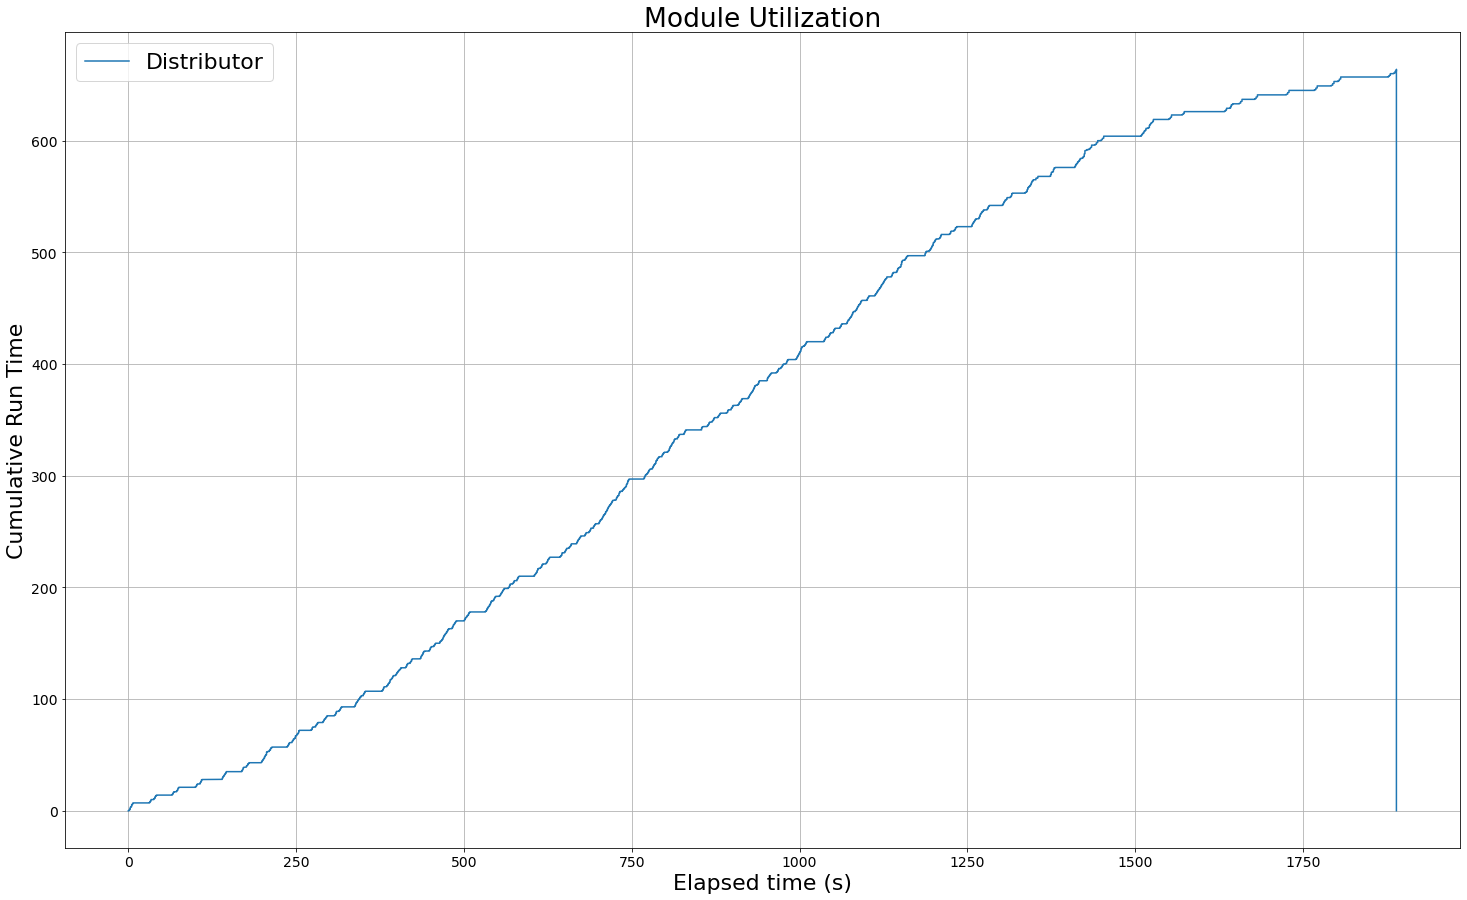

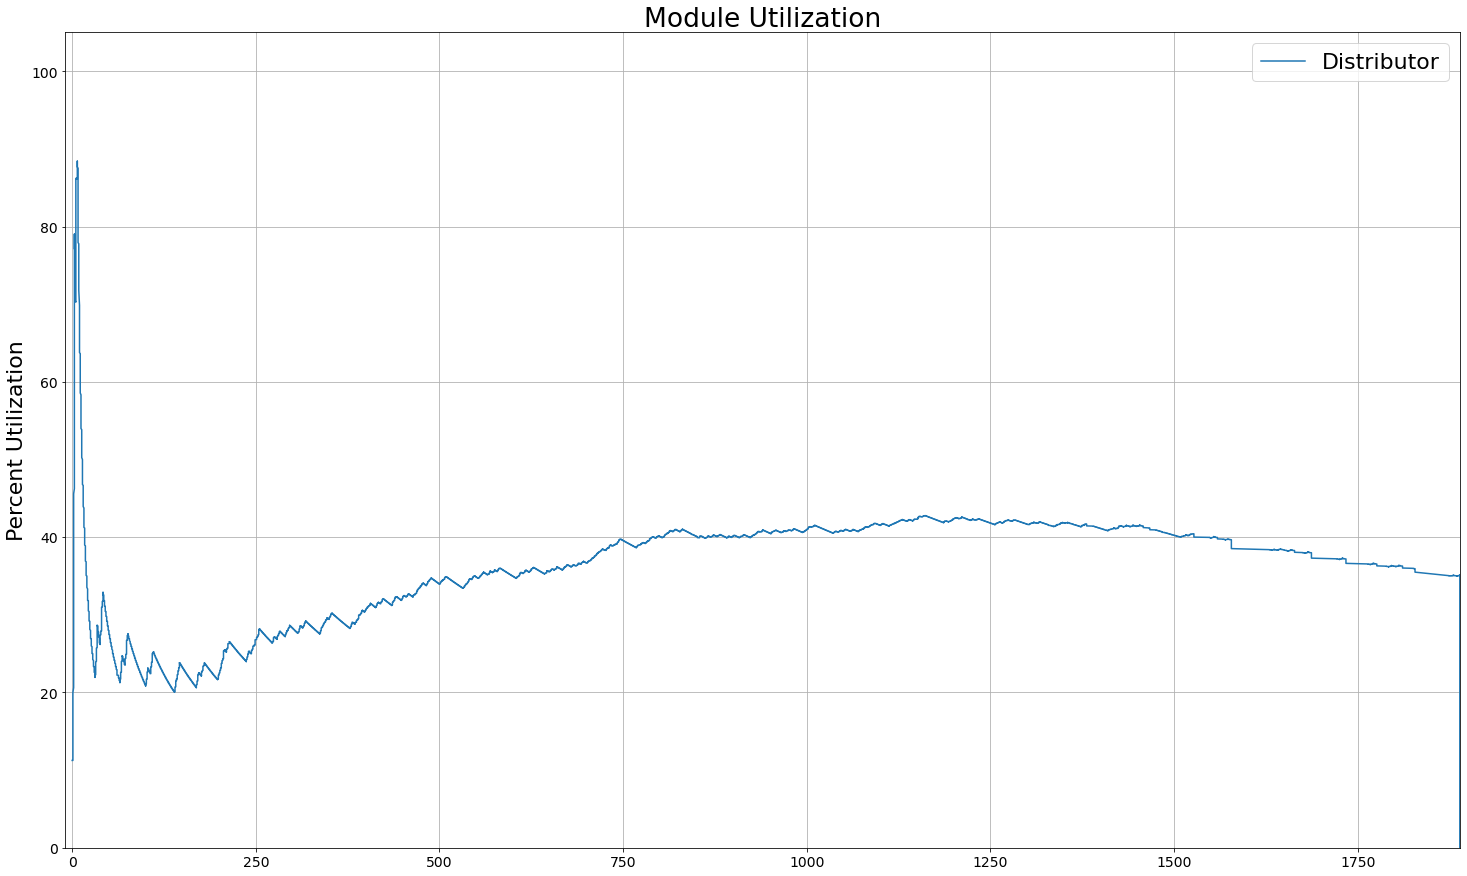

In [42]:
##### Distributor Utilization - computation of distributor utilization. Utilization is defined as the percentage of time that a module is used (refer to the Throughput Presentation for further explanation). As an example if a module is used for 5 of first 5 seconds of an experiment the percent utilization at 5 seconds would be 100 percent. Similarly if a
# module is used for 2.5 seconds of the first 5 seconds at 5 seconds the percent utilization would be 50%. A nuance is that I programmed this to handle "end of use" of a module meaning that if a module is no longer used the utilization drops to zero percent and is held there. Otherwise the utilization would trail off as the total time increased and the sum
# utilization time remained static (which is ugly and kinda useless on the plots). Also note that the loop creating the utilization vector linearly interpolates between points such that the utilization vector has the same length as the original "Elapsed Time" vector from the "test_data." "

dist_Cmds = ['IOModuleDriver[Transfer].TransferDistributorCmd - [Source: LoadingLane; Destination: Distributor; ]','IOModuleDriver[Transfer].TransferDistributorCmd - [Source: Distributor; Destination: LaneSwitchPresenter; ]','IOModuleDriver[Transfer].TransferDistributorCmd - [Source: Distributor; Destination: UnloadingLane; ]',\
            'IOModuleDriver[Transfer].TransferDistributorCmd - [Source: LaneSwitchToTrackModule; Destination: Distributor; ]','IOModuleDriver[Transfer].TransferDistributorCmd - [Source: Distributor; Destination: LeftBuffer','IOModuleDriver[Transfer].TransferDistributorCmd - [Source: Distributor; Destination: RightBuffer',\
            ]
dist_Rsps = ['IOModuleDriver[Transfer].TransferDistributorRsp - [Source: LoadingLane; Destination: Distributor; ]','IOModuleDriver[Transfer].TransferDistributorRsp - [Source: Distributor; Destination: LaneSwitchPresenter; ]','IOModuleDriver[Transfer].TransferDistributorRsp - [Source: Distributor; Destination: UnloadingLane; ]',\
            'IOModuleDriver[Transfer].TransferDistributorRsp - [Source: LaneSwitchToTrackModule; Destination: Distributor; ]','IOModuleDriver[Transfer].TransferDistributorRsp - [Source: Distributor; Destination: LeftBuffer','IOModuleDriver[Transfer].TransferDistributorRsp - [Source: Distributor; Destination: RightBuffer',\
            ]

indexin = []
indexout = [] 

#Store indexes of start and stop of actions. This uses find function but could use string compare 
for l in test_data.index: #loop over indexes in the test_data vector
#     l = str(l)
    for cmds in dist_Cmds: #loop over command messages associated with start of distributor actions
        if (str(test_data['Title'][l]).find(cmds) != -1): #find search command in Title at current index l
            indexin.append(l) #store index if found
    for rsps in dist_Rsps: # loop over response messages associated with end of distributor actions 
        if (str(test_data['Title'][l]).find(rsps) != -1): #find search command in Title at current index l
            indexout.append(l) #store index if found

distins = test_data.loc[indexin] #create a new DataFrame with dota for Command messages
distouts = test_data.loc[indexout] #create a new DataFrame with dota for Response messages

dist_time = distouts.ElapsedTime.reset_index(drop=True) - distins.ElapsedTime.reset_index(drop=True) #determine the time to complete all performed actions by subtracting the start action time of each action from the end action time of each action.
dist_time_cumsum = [0] + list(np.cumsum(dist_time)) #creation of a cumulative sum vector. A initial value of zero is added to the front of the vector because the cumsum method produces a vector of length one less than the input vector (0th element of cumsum output is sum of 0th and 1st from input)

####
flag=False #This flag is used to flag when a command is detected 
cnt = 0  #This counter is used to count the number of commands detected
dist_ult_timeseries = []

#This loop produces the vector representing the cumulative time that a module has been utilized. The loops iterates over the indexes of the test_data and sets the flag to true when the Title at the iteration index, l, is a command
#and increments the cnt. When the iteration index, l, is a response message it sets the flag to false. This is done because when the module is performing an action you need to add to its cumulative time and when the module is not active its cumulative time remains the same.
#SO essentially this flag alters the behavior of the loop in the if section which then alters the behavior of the loop
for l in test_data.index:
    for cmds in dist_Cmds:
        if (str(test_data['Title'][l]).find(cmds) != -1):
            cnt += 1
            flag = True
    for rsps in dist_Rsps:
        if (str(test_data['Title'][l]).find(rsps) != -1):
            flag = False   
        
    if flag == False and (cnt < len(dist_time_cumsum) - 1):
        dist_ult_timeseries.append(dist_time_cumsum[cnt]) #maintains previous cumulative time if flag is false AND this is not the last command
    elif flag == True: 
        dist_ult_timeseries.append(((dist_time_cumsum[cnt]-dist_time_cumsum[cnt-1])/(indexout[cnt-1]-indexin[cnt-1]))*(l-indexin[cnt-1])+dist_time_cumsum[cnt-1]) #linearly interpolates between previous and present value to ensure that the length of "dist_ult_timeseries" is equal to test_data.Elapsed_Time (for plotting purposes)
    elif (cnt == ((len(dist_time_cumsum)) - 1)):
        dist_ult_timeseries.append(0) #if module is no longer used simply put a zero for the cumulative sum
####

####
elapsed_time_corrected = []
cnt=0

#This loop corrects a problem with independent vector for plotting "Elapsed_Time"
#This vector in its raw form contains duplicates. Because unix time came out to be an integer number and it rounds you see things like this: [0, 1, 1, 1, 2, 2, 3, 3, 3]
#This loop creates a new Elapsed_Time vector using the np.linspace function to linearly space the point within these clusters like [0, 0.33, 0.66, 1, 1.5, 2, 2.33, 2.66, 3]
#This maintains the same over time scale meaning the position of the right most integer values in any cluster of identical values remains the same (the rightmost 1, 2 and 3 in their respective clusers are element 3, 5, and 8 as they are in the original vector)
for n in range(0,len(test_data['ElapsedTime'])-1):
    if test_data['ElapsedTime'][test_data.index[n+1]] == test_data['ElapsedTime'][test_data.index[n]]:
        cnt+=1
    else: 
        elapsed_time_corrected = elapsed_time_corrected + list(np.linspace(test_data['ElapsedTime'][test_data.index[n-cnt]],test_data['ElapsedTime'][test_data.index[n+1]],cnt+2)[0:-1])
        cnt=0
if len(elapsed_time_corrected) < len(dist_ult_timeseries):
    elapsed_time_corrected = elapsed_time_corrected + list(np.ones(len(dist_ult_timeseries)-len(elapsed_time_corrected))*max(test_data['ElapsedTime']))
# elapsed_time_corrected = np.linspace(0,max(test_data['ElapsedTime']),len(test_data['ElapsedTime']))
####

dist_ult_timeseries_percent = np.true_divide(dist_ult_timeseries,elapsed_time_corrected)*100 #converts the cumulative sum of module actions vector to a percentage utilization by element-wise true division using numpy

print("Distributor Median Percent Utilization")
print(round(np.nanmedian(dist_ult_timeseries_percent))) #displays the median percent utilization. However, for something like the distributor this is not a particularly useful metric. 

#The following block stores summary information in the "summary" data structure initialized in the first cell
summary["Distributor Percent Utilization"] = []
summary["Distributor Percent Utilization"].append(round(np.nanmedian(dist_ult_timeseries_percent),2))
# summary["Distributor Percent Utilization"].append(round(np.nanstd(dist_ult_timeseries_percent),2))
summary["Distributor Percent Utilization"].append(np.NaN)
summary["Distributor Percent Utilization"].append(round(np.nanmax(dist_ult_timeseries_percent),2))
# summary["Distributor Percent Utilization"].append(round(np.nanmin(dist_ult_timeseries_percent),2))

#All figures have a number of modifying parameters that the use might want to change check these before runnining the program.
#Figure of the distributor cumulative time utilization - recall that flat regions indicate down time
figure(1)
plot(test_data['ElapsedTime'],dist_ult_timeseries, label='Distributor')
title('Module Utilization')
xlabel('Elapsed time (s)')
ylabel('Cumulative Run Time')
# xlim(0,100)
# ylim(0,100)
legend()
grid(True)

#figure of the percentage utilization over time
figure(2)
plot(test_data['ElapsedTime'],dist_ult_timeseries_percent, label='Distributor')
title('Module Utilization')
ylabel('Percent Utilization')
legend()
ylim(0,105)
xlim(-10,max(test_data['ElapsedTime']))
grid(True)

In [49]:
##Additional application of 'command_analyzer' to analyze lane switch track timings
#detecting the messages corresponding to this component depends on knowing which side of the IO module has been configured to be the lane switch track.
#by changing the varialbe lane_switch_track to equal 'left' or 'right' you effectively change the message searched for using f-string modification in the search routine.


lane_switch_track = 'Right'
lane_switch_presenter = 'Left'

# Extraction of timings and statistics associated with lane switch right movement actions
print('\nAnalyzing Lane Switch Track Movement')
output = command_analyzer(f'IOLaneSwitch{lane_switch_track}[LaneSwitchDrive].MoveLaneSwitchToPositionCmd',f'IOLaneSwitch{lane_switch_track}[LaneSwitchDrive].MoveLaneSwitchToPositionRsp', test_data)
if output != False:
    print('Matched Commands Present Proceeding')
    LST_time = output[2]
    LST_stats = output[3]
    print('Lane Switch Track to Distributor:')
    print(LST_stats)
else:
    print('Non matched commands')
    
# Extraction of timings and statistics associated with lane switch right actions
print('\nAnalyzing Lane Switch Track Loading')
output = command_analyzer(f'IOLaneSwitch{lane_switch_track}[TrackControl].TransferRackCmd - [MoveDirection: AwayFromIoModule; TransferLoading: Load; ]',f'IOLaneSwitch{lane_switch_track}[TrackControl].TransferRackRsp - [MoveDirection: AwayFromIoModule; TransferLoading: Load; ]', test_data)
if output != False:
    print('Matched Commands Present Proceeding')
    LSTL_time = output[2]
    LSTL_stats = output[3]
    print('Lane Switch Track to Distributor:')
    print(LSTL_stats)
else:
    print('Non matched commands')
    
# Extraction of timings and statistics associated with lane switch right unloading
print('\nAnalyzing Lane Switch Track Unloading')
output = command_analyzer(f'IOLaneSwitch{lane_switch_track}[TrackControl].TransferRackCmd - [MoveDirection: AwayFromIoModule; TransferLoading: Unload; ]',f'IOLaneSwitch{lane_switch_track}[TrackControl].TransferRackRsp - [MoveDirection: AwayFromIoModule; TransferLoading: Unload; ]', test_data)
if output != False:
    print('Matched Commands Present Proceeding')
    LSTUL_time = output[2]
    LSTUL_stats = output[3]
    print('Lane Switch Track to Distributor:')
    print(LSTUL_stats)
else:
    print('Non matched commands')

lane_switch_1_time = np.sum(LST_time) + np.sum(LSTL_time) + np.sum(LSTUL_time)
lane_switch_1_util = round(lane_switch_1_time / run_time,2)


Analyzing Lane Switch Track Movement
Matched Commands Present Proceeding
Lane Switch Track to Distributor:
DescribeResult(nobs=144, minmax=(0.0, 2.0), mean=0.7152777777777778, variance=0.26102369852369856, skewness=-0.30484829767660643, kurtosis=-0.5918179340183882)

Analyzing Lane Switch Track Loading
Matched Commands Present Proceeding
Lane Switch Track to Distributor:
DescribeResult(nobs=37, minmax=(1.0, 2.0), mean=1.9189189189189189, variance=0.07657657657657657, skewness=-3.069457383227691, kurtosis=7.421568627450979)

Analyzing Lane Switch Track Unloading
Matched Commands Present Proceeding
Lane Switch Track to Distributor:
DescribeResult(nobs=35, minmax=(0.0, 1.0), mean=0.9714285714285714, variance=0.028571428571428574, skewness=-5.659453309702791, kurtosis=30.029411764705863)


<ipython-input-43-bbcc77e2d246>:54: RuntimeWarning: invalid value encountered in true_divide
  lst_ult_timeseries_percent = np.true_divide(lst_ult_timeseries,elapsed_time_corrected)*100


LS Track Median Percent Utilization
14


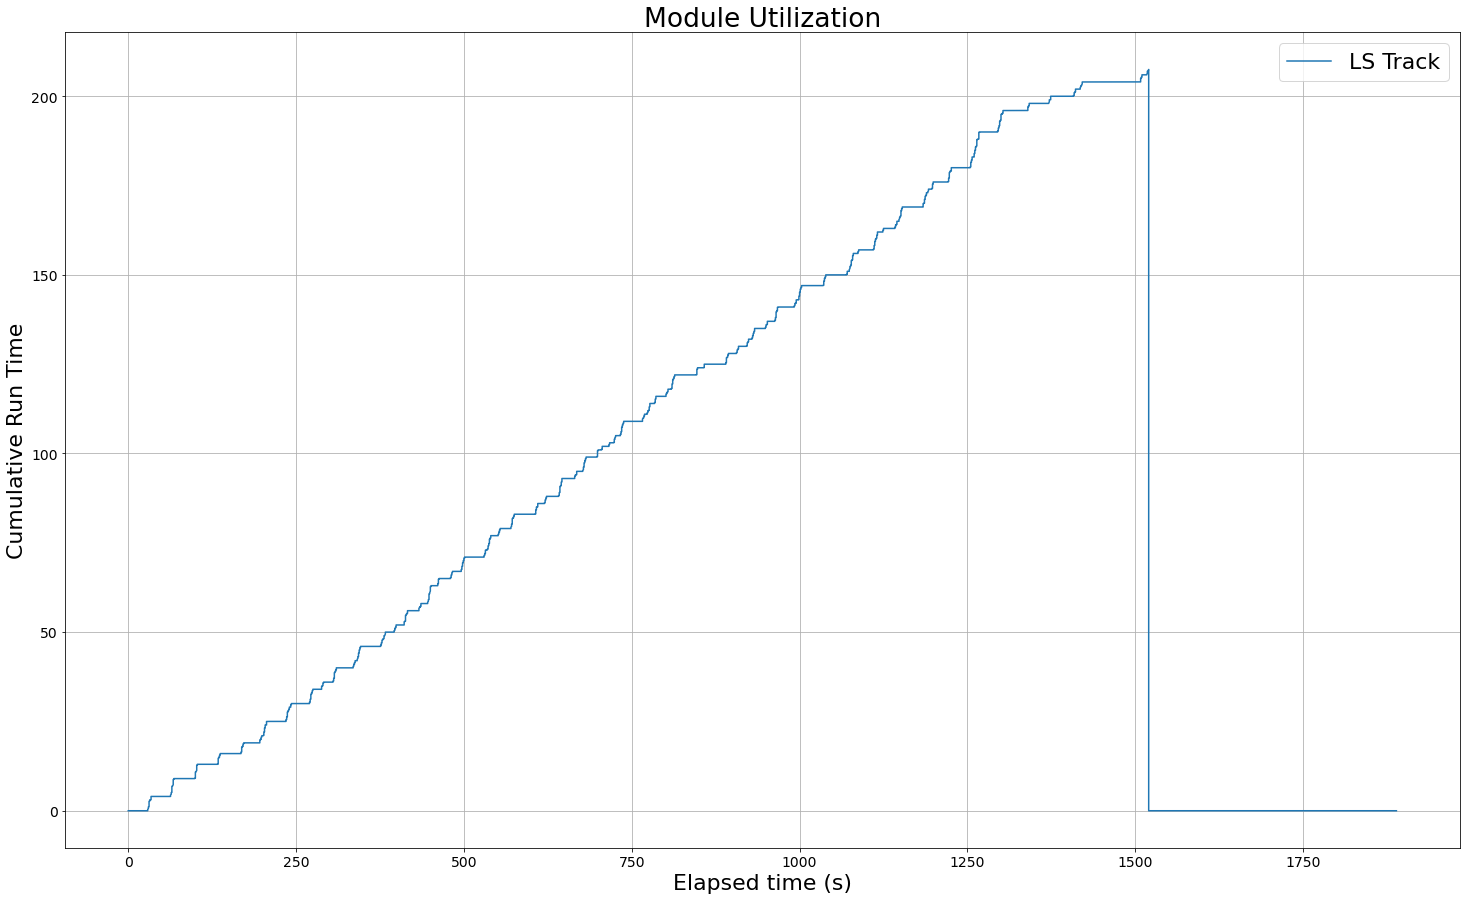

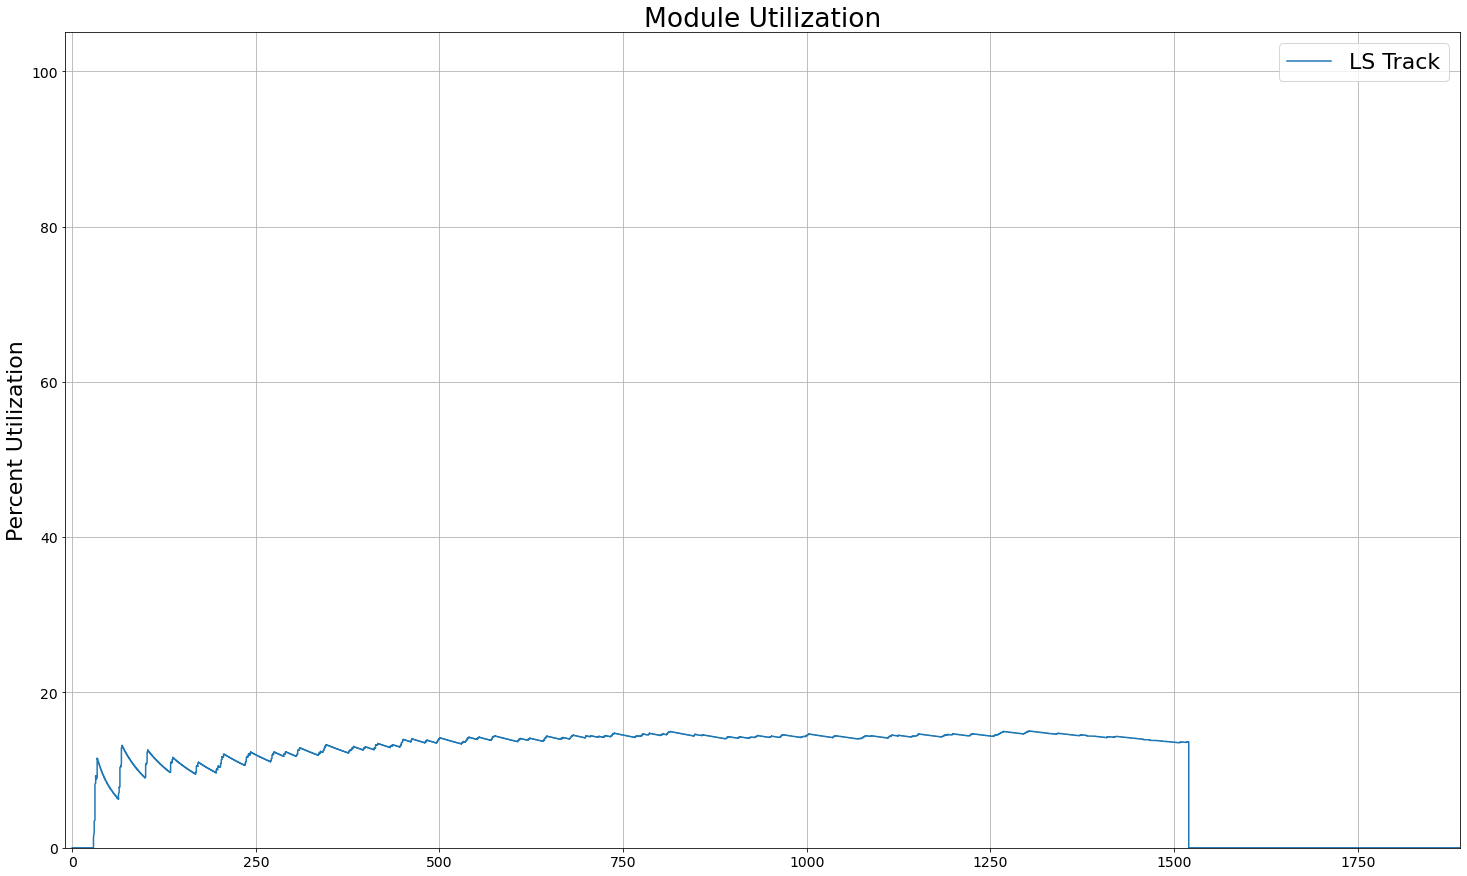

In [43]:
##Lane Switch Track Utilization
#see the distributor utilization cell for explanation of what this cell is doing. The loops and such in this cell are essentially copied from the distributor version.

lane_switch_track = 'Right'

lst_Cmds = [f'IOLaneSwitch{lane_switch_track}[LaneSwitchDrive].MoveLaneSwitchToPositionCmd', f'IOLaneSwitch{lane_switch_track}[TrackControl].TransferRackCmd - [MoveDirection: AwayFromIoModule; TransferLoading: Load; ]', \
           f'IOLaneSwitch{lane_switch_track}[TrackControl].TransferRackCmd - [MoveDirection: AwayFromIoModule; TransferLoading: Unload; ]']
lst_Rsps = [f'IOLaneSwitch{lane_switch_track}[LaneSwitchDrive].MoveLaneSwitchToPositionRsp', f'IOLaneSwitch{lane_switch_track}[TrackControl].TransferRackRsp - [MoveDirection: AwayFromIoModule; TransferLoading: Load; ]', \
           f'IOLaneSwitch{lane_switch_track}[TrackControl].TransferRackRsp - [MoveDirection: AwayFromIoModule; TransferLoading: Unload; ]']

indexin = []
indexout = [] 

# print(pre_time_cumsum[cnt+1]) 
for l in test_data.index:
#     l = str(l)
    for cmds in lst_Cmds:
        if (str(test_data['Title'][l]).find(cmds) != -1):
            indexin.append(l)
    for rsps in lst_Rsps:
        if (str(test_data['Title'][l]).find(rsps) != -1):
            indexout.append(l)

lstins = test_data.loc[indexin]
lstouts = test_data.loc[indexout]

lst_time = lstouts.ElapsedTime.reset_index(drop=True) - lstins.ElapsedTime.reset_index(drop=True)
adwda = [0]
lst_time_cumsum = adwda + list(np.cumsum(lst_time))
# print(lst_time_cumsum)

flag=False
cnt = 0 
lst_ult_timeseries = []

for l in test_data.index:
    for cmds in lst_Cmds:
        if (str(test_data['Title'][l]).find(cmds) != -1):
            cnt += 1
            flag = True
    for rsps in lst_Rsps:
        if (str(test_data['Title'][l]).find(rsps) != -1):
            flag = False   
        
#  and (cnt<len(indexin))
    if flag == False and (cnt < len(lst_time_cumsum) - 1):
        lst_ult_timeseries.append(lst_time_cumsum[cnt])
#         print(present_ult_timeseries)
    elif flag == True:
#         print(cnt)
#         print(l)
#         print(indexin)
        lst_ult_timeseries.append(((lst_time_cumsum[cnt]-lst_time_cumsum[cnt-1])/(indexout[cnt-1]-indexin[cnt-1]))*(l-indexin[cnt-1])+lst_time_cumsum[cnt-1])
    elif (cnt == ((len(lst_time_cumsum)) - 1)):
        lst_ult_timeseries.append(0)
        
lst_ult_timeseries_percent = np.true_divide(lst_ult_timeseries,elapsed_time_corrected)*100 #note that this uses elapsed_time_correct which is defined in a previous cell meaning that cell MUST be run prior to this cell

print("LS Track Median Percent Utilization")
print(round(np.nanmedian(lst_ult_timeseries_percent)))
summary["LS Track Percent Utilization"] = []
summary["LS Track Percent Utilization"].append(round(np.nanmedian(lst_ult_timeseries_percent),2))
# summary["LS Track Percent Utilization"].append(round(np.nanstd(lst_ult_timeseries_percent),2))
summary["LS Track Percent Utilization"].append(np.NaN)
summary["LS Track Percent Utilization"].append(round(np.nanmax(lst_ult_timeseries_percent),2))
# summary["LS Track Percent Utilization"].append(round(np.nanmin(lst_ult_timeseries_percent),2))


figure(3)
plot(test_data['ElapsedTime'],lst_ult_timeseries, label='LS Track')
title('Module Utilization')
xlabel('Elapsed time (s)')
ylabel('Cumulative Run Time')
# xlim(0,100)
# ylim(0,100)
legend()
grid(True)

figure(4)
plot(test_data['ElapsedTime'],lst_ult_timeseries_percent, label='LS Track')
title('Module Utilization')
ylabel('Percent Utilization')
legend()
ylim(0,105)
xlim(-10,max(test_data['ElapsedTime']))
grid(True)

In [12]:
##Analyzer Input Timing Analysis
#These data are used to assess the degree to which the analyzers are limited or limiting. For example if the time in the input q is the lowest it can be (which is not zero) then the analyzer has released a previous rack and is immediately able to accept the newly arrived rack. 
#Likewise if the anaylzer input q is occupied for a considerable amount of time the analyzer is limiting. 
#Once again similar to the previous utilization cells
#There one slight difference here wrt the previous utlization cells in that I wrapped the analysis in a loop which loops through the analyzers and stores the relevant data in dicts
#data is printed for each analyzer by using f-strings with the iterator, N, to modify the print statement for clarity.

AIU_time = {}
AIU_stats = {}
AIU_time_sum = {}
AIU_util = {}
Analyzer_used = {}

#Extraction of analyzer input utilization (InnerTrackShort)
for N in range(1,7,1):
    
    indexs = []
    for l in test_data['Title']:
        l = str(l)
    #     print(l)
        if (l.find(f"Track{N}Main[TrackControlInnerTrackShort].TransferRackCmd - [MoveDirection: AwayFromIoModule; TransferLoading: Load; ]") != -1) or (l.find(f'Track{N}Main[TrackControlInnerTrackShort].TransferRackRsp - [MoveDirection: AwayFromIoModule; TransferLoading: Unload; ]') != -1):
            indexs.append(True)
        else:
            indexs.append(False)

    AIU = test_data.loc[indexs]
    # print(AIU.Title)
    # print(len(D2UL['Title']))

    if (len(AIU['Title']) % 2 == 0) and (len(AIU['Title']) > 0) :
        print(f"Analyzing Analyzer {N} Input Utilization")
        print('Matched Commands Present Proceeding')
        AIU_time[f"Analyzer {N} Input"] = (AIU.UnixTime[1::2].reset_index(drop=True) - AIU.UnixTime[::2].reset_index(drop=True))
        AIU_stats[f"Analyzer {N} Input"] = stats.describe(AIU_time[f"Analyzer {N} Input"])

        print(f"Analyzer {N} Input Utilization:")
        print(AIU_stats[f"Analyzer {N} Input"])

        AIU_time_sum[f"Analyzer {N} Input"] = np.sum(AIU_time[f"Analyzer {N} Input"])
        AIU_util[f"Analyzer {N} Input"] = round(AIU_time_sum[f"Analyzer {N} Input"]/run_time * 100,2)
        Analyzer_used[f"Analyzer {N}"] = True
    else:
        print(f'Non matched commands or Analyzer {N} not used')
        Analyzer_used[f"Analyzer {N}"] = False

Analyzing Analyzer 1 Input Utilization
Matched Commands Present Proceeding
Analyzer 1 Input Utilization:
DescribeResult(nobs=8, minmax=(14.0, 144.0), mean=57.125, variance=2537.839285714286, skewness=0.9571719014235831, kurtosis=-0.7596746037165607)
Analyzing Analyzer 2 Input Utilization
Matched Commands Present Proceeding
Analyzer 2 Input Utilization:
DescribeResult(nobs=7, minmax=(14.0, 63.0), mean=34.142857142857146, variance=437.47619047619054, skewness=0.21468242570715315, kurtosis=-1.5522435589572443)
Analyzing Analyzer 3 Input Utilization
Matched Commands Present Proceeding
Analyzer 3 Input Utilization:
DescribeResult(nobs=6, minmax=(14.0, 53.0), mean=32.833333333333336, variance=250.16666666666666, skewness=-0.22522155322861684, kurtosis=-1.3666655984617844)
Analyzing Analyzer 4 Input Utilization
Matched Commands Present Proceeding
Analyzer 4 Input Utilization:
DescribeResult(nobs=6, minmax=(14.0, 143.0), mean=55.5, variance=4093.9, skewness=0.7147518716706373, kurtosis=-1.4780

<ipython-input-13-518f4c2df91a>:56: RuntimeWarning: invalid value encountered in true_divide
  AIU_ult_timeseries_percent[f"Analyzer {N}"] = np.true_divide(AIU_ult_timeseries[f"Analyzer {N}"],elapsed_time_corrected)*100


Analyzer 1 Median Percent Utilization
20


<ipython-input-13-518f4c2df91a>:56: RuntimeWarning: invalid value encountered in true_divide
  AIU_ult_timeseries_percent[f"Analyzer {N}"] = np.true_divide(AIU_ult_timeseries[f"Analyzer {N}"],elapsed_time_corrected)*100


Analyzer 2 Median Percent Utilization
16


<ipython-input-13-518f4c2df91a>:56: RuntimeWarning: invalid value encountered in true_divide
  AIU_ult_timeseries_percent[f"Analyzer {N}"] = np.true_divide(AIU_ult_timeseries[f"Analyzer {N}"],elapsed_time_corrected)*100


Analyzer 3 Median Percent Utilization
13


<ipython-input-13-518f4c2df91a>:56: RuntimeWarning: invalid value encountered in true_divide
  AIU_ult_timeseries_percent[f"Analyzer {N}"] = np.true_divide(AIU_ult_timeseries[f"Analyzer {N}"],elapsed_time_corrected)*100


Analyzer 4 Median Percent Utilization
21


<ipython-input-13-518f4c2df91a>:56: RuntimeWarning: invalid value encountered in true_divide
  AIU_ult_timeseries_percent[f"Analyzer {N}"] = np.true_divide(AIU_ult_timeseries[f"Analyzer {N}"],elapsed_time_corrected)*100


Analyzer 5 Median Percent Utilization
4


<ipython-input-13-518f4c2df91a>:56: RuntimeWarning: invalid value encountered in true_divide
  AIU_ult_timeseries_percent[f"Analyzer {N}"] = np.true_divide(AIU_ult_timeseries[f"Analyzer {N}"],elapsed_time_corrected)*100


Analyzer 6 Median Percent Utilization
3


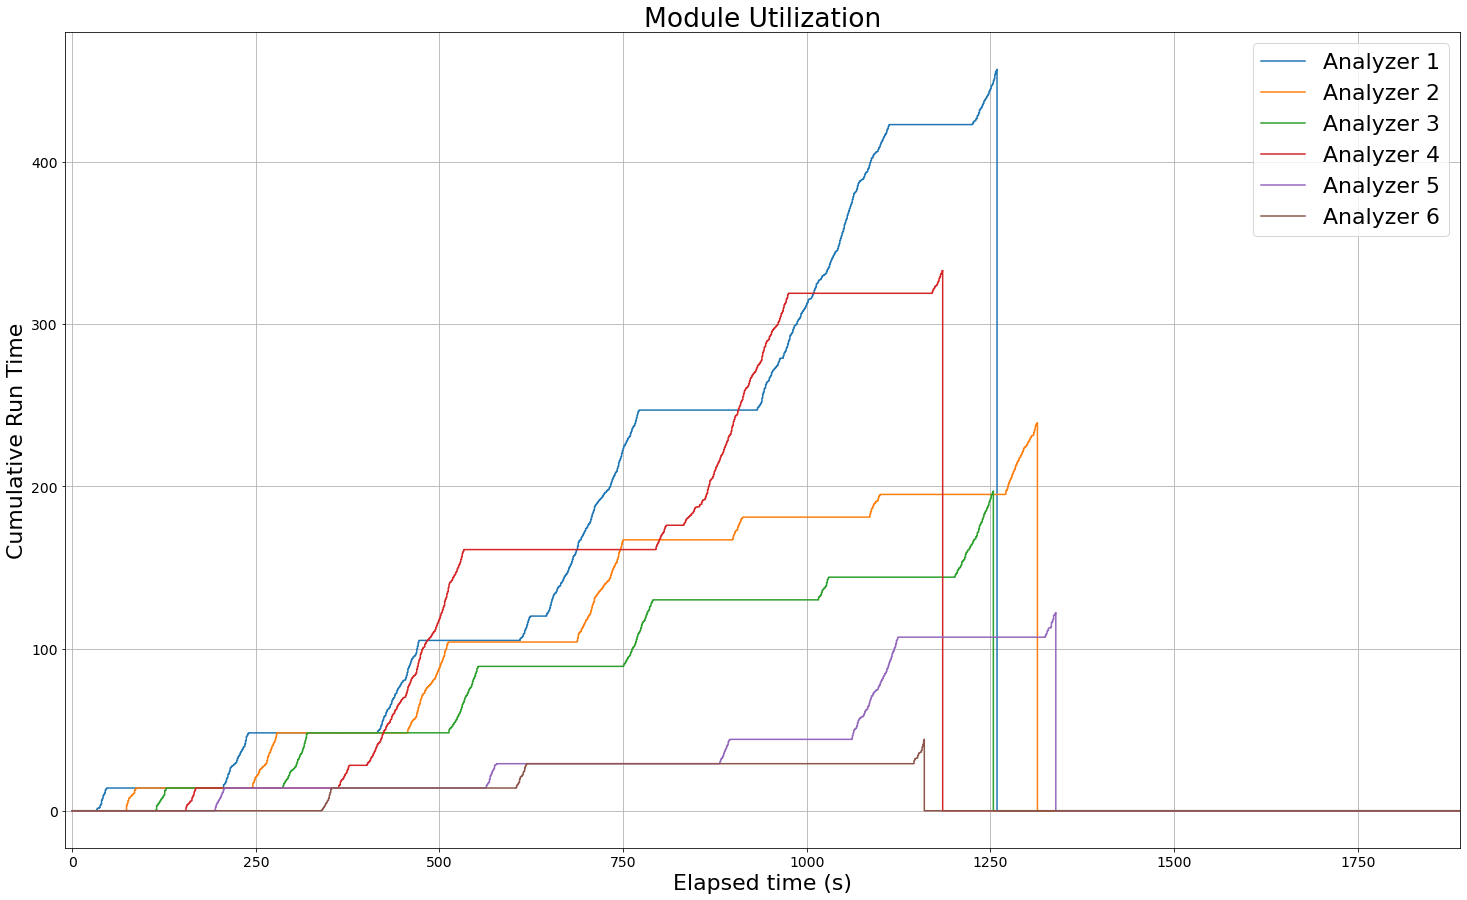

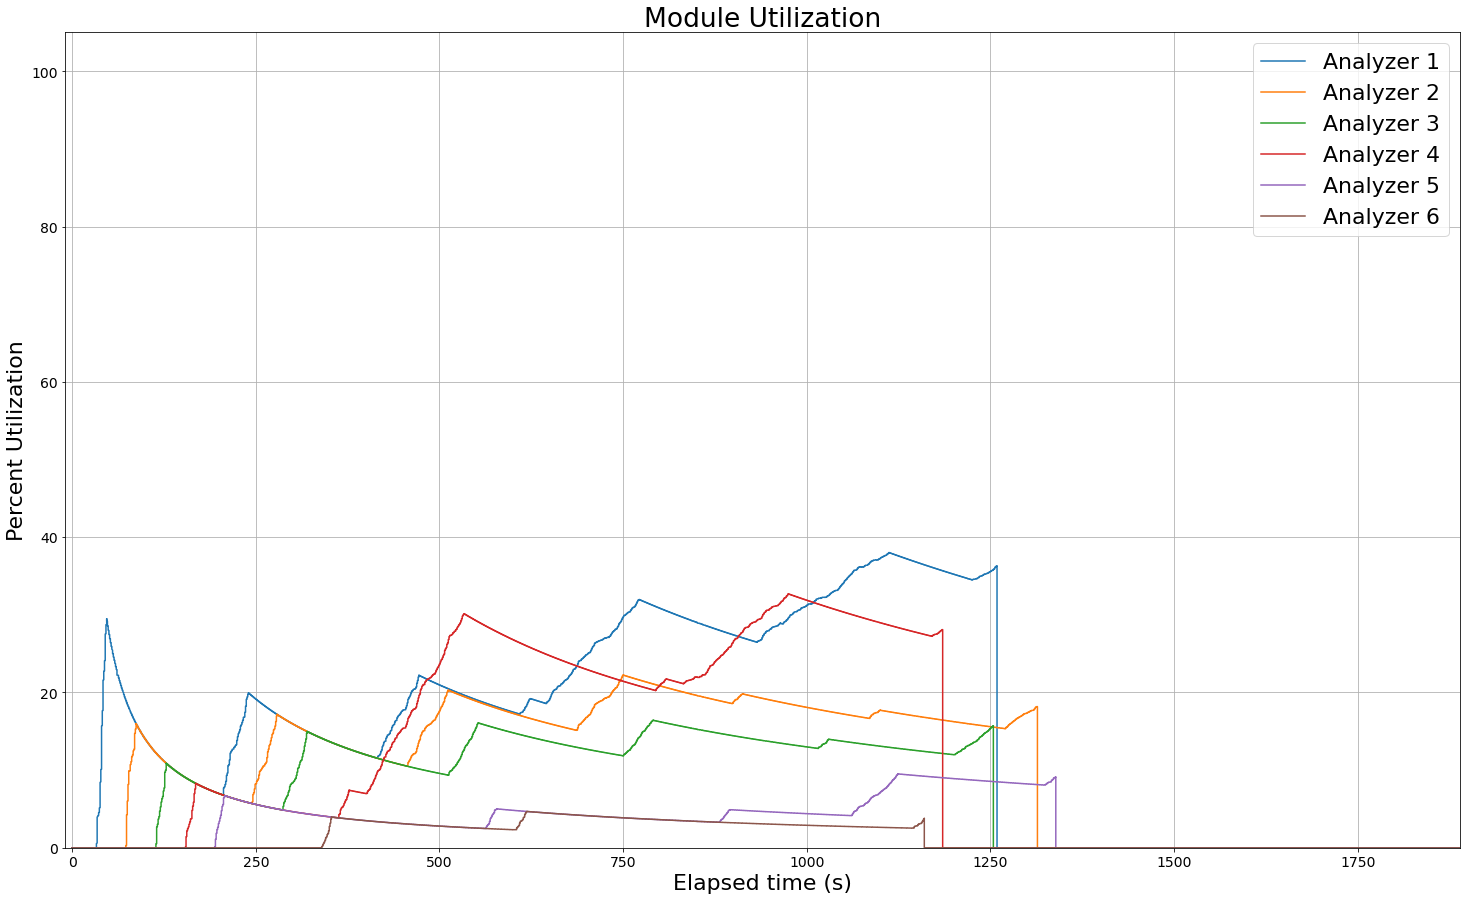

In [13]:
##Analyzer Input Utilization Analysis
#There is virtually nothing different about this utilization cell compared to the other...it also uses the same method of looping over analyzer numbers
#results are stored in dicts with analyzer specific naming conventions for the keys generated the same way as before; f-string using loop iterator

AIU_time = {}
AIU_time_cumsum = {}
AIU_ult_timeseries = {}
AIU_ult_timeseries_percent = {}

for N in range(1,7,1):
    
    AIU_Cmds = [f"Track{N}Main[TrackControlInnerTrackShort].TransferRackCmd - [MoveDirection: AwayFromIoModule; TransferLoading: Load; ]"]
    AIU_Rsps = [f'Track{N}Main[TrackControlInnerTrackShort].TransferRackRsp - [MoveDirection: AwayFromIoModule; TransferLoading: Unload; ]']
    indexin = []
    indexout = [] 

    # print(pre_time_cumsum[cnt+1]) 
    for l in test_data.index:
    #     l = str(l)
        for cmds in AIU_Cmds:
            if (str(test_data['Title'][l]).find(cmds) != -1):
                indexin.append(l)
        for rsps in AIU_Rsps:
            if (str(test_data['Title'][l]).find(rsps) != -1):
                indexout.append(l)

    AIUins = test_data.loc[indexin]
    AIUouts = test_data.loc[indexout]

    AIU_time[f"Analyzer {N}"] = AIUouts.ElapsedTime.reset_index(drop=True) - AIUins.ElapsedTime.reset_index(drop=True)
    AIU_time_cumsum[f"Analyzer {N}"] = [0] + list(np.cumsum(AIU_time[f"Analyzer {N}"]))

    flag=False
    cnt = 0 
    AIU_ult_timeseries[f"Analyzer {N}"] = []

    for l in test_data.index:
        for cmds in AIU_Cmds:
            if (str(test_data['Title'][l]).find(cmds) != -1):
                cnt += 1
                flag = True
        for rsps in AIU_Rsps:
            if (str(test_data['Title'][l]).find(rsps) != -1):
                flag = False   

    #  and (cnt<len(indexin))
        if flag == False and (cnt < len(AIU_time_cumsum[f"Analyzer {N}"]) - 1):
            AIU_ult_timeseries[f"Analyzer {N}"].append(AIU_time_cumsum[f"Analyzer {N}"][cnt])
    #         print(present_ult_timeseries)
        elif flag == True:
    #         print(cnt)
    #         print(l)
    #         print(indexin)
            AIU_ult_timeseries[f"Analyzer {N}"].append(((AIU_time_cumsum[f"Analyzer {N}"][cnt]-AIU_time_cumsum[f"Analyzer {N}"][cnt-1])/(indexout[cnt-1]-indexin[cnt-1]))*(l-indexin[cnt-1])+AIU_time_cumsum[f"Analyzer {N}"][cnt-1])
        elif (cnt == ((len(AIU_time_cumsum[f"Analyzer {N}"])) - 1)):
            AIU_ult_timeseries[f"Analyzer {N}"].append(0)
    
    AIU_ult_timeseries_percent[f"Analyzer {N}"] = np.true_divide(AIU_ult_timeseries[f"Analyzer {N}"],elapsed_time_corrected)*100
    
    if Analyzer_used[f"Analyzer {N}"] == True: 
        print(f"Analyzer {N} Median Percent Utilization")
        print(round(np.nanmedian(AIU_ult_timeseries_percent[f"Analyzer {N}"])))
        
        summary[f"Analyzer {N} Percent Utilization"] = []
        summary[f"Analyzer {N} Percent Utilization"].append(round(np.nanmedian(AIU_ult_timeseries_percent[f"Analyzer {N}"]),2))
#         summary[f"Analyzer {N} Percent Utilization"].append(round(np.nanstd(AIU_ult_timeseries_percent[f"Analyzer {N}"]),2))
        summary[f"Analyzer {N} Percent Utilization"].append(np.NaN)
        summary[f"Analyzer {N} Percent Utilization"].append(round(np.nanmax(AIU_ult_timeseries_percent[f"Analyzer {N}"]),2))
#         summary[f"Analyzer {N} Percent Utilization"].append(round(np.nanmin(AIU_ult_timeseries_percent[f"Analyzer {N}"]),2))
    
    figure(5) #adds the cumulative time to a figure if the analyzer was used
    if Analyzer_used[f"Analyzer {N}"] == True:
        plot(test_data['ElapsedTime'],AIU_ult_timeseries[f"Analyzer {N}"], label=f'Analyzer {N}')
    title('Module Utilization')
    xlabel('Elapsed time (s)')
    ylabel('Cumulative Run Time')
    xlim(-10,max(test_data['ElapsedTime']))
    # ylim(0,100)
    legend()
    grid(True)
    legend()
    
    figure(6) #adds the utilization percentage to a figure if the analyzer was used
    if Analyzer_used[f"Analyzer {N}"] == True:
        plot(test_data['ElapsedTime'],AIU_ult_timeseries_percent[f"Analyzer {N}"], label=f'Analyzer {N}')
    title('Module Utilization')
    xlabel('Elapsed time (s)')
    ylabel('Percent Utilization')
    legend()
    ylim(0,105)
    xlim(-10,max(test_data['ElapsedTime']))
    grid(True)
    legend()

In [14]:
##Timing Analysis of the Short Track and the Long Track sections of the inner lane to establish their travel times.
#This cell was generated to help assess the travel times on the two segments of the inner lane. This works well with the segment which is not serving as the analyzer input.
#For the segment that is the travel time is no explicitly the result of this analysis because the timings also include the wait time in the segment waiting for the pipetting position
#to become available

#Long Track Segment Analysis
LT_time = {}
for N in range(1,7,1):
    
    LT_Cmds = [f"Track{N}Main[TrackControlInnerTrackLong].TransferRackCmd - [MoveDirection: AwayFromIoModule; TransferLoading: Load; ]"]
    LT_Rsps = [f'Track{N}Main[TrackControlInnerTrackLong].TransferRackRsp - [MoveDirection: AwayFromIoModule; TransferLoading: Unload; ]']
    indexin = []
    indexout = [] 

    # print(pre_time_cumsum[cnt+1]) 
    for l in test_data.index:
    #     l = str(l)
        for cmds in LT_Cmds:
            if (str(test_data['Title'][l]).find(cmds) != -1):
                indexin.append(l)
        for rsps in LT_Rsps:
            if (str(test_data['Title'][l]).find(rsps) != -1):
                indexout.append(l)

    LTins = test_data.loc[indexin]
    LTouts = test_data.loc[indexout]

    LT_time[f"Analyzer {N}"] = LTouts.ElapsedTime.reset_index(drop=True) - LTins.ElapsedTime.reset_index(drop=True)
    if Analyzer_used[f"Analyzer {N}"] == True:
        print(f"Analyzer {N} Long Track Times")
        print(LT_time[f"Analyzer {N}"])

#Short Track Segment Analysis
ST_time = {}
STCT_time = {}
for N in range(1,7,1):
    
    ST_Cmds = [f"Track{N}Main[TrackControlInnerTrackShort].TransferRackCmd - [MoveDirection: AwayFromIoModule; TransferLoading: Load; ]"]
    ST_Rsps = [f'Track{N}Main[TrackControlInnerTrackShort].TransferRackRsp - [MoveDirection: AwayFromIoModule; TransferLoading: Unload; ]']
    indexin = []
    indexout = [] 

    # print(pre_time_cumsum[cnt+1]) 
    for l in test_data.index:
    #     l = str(l)
        for cmds in ST_Cmds:
            if (str(test_data['Title'][l]).find(cmds) != -1):
                indexin.append(l)
        for rsps in ST_Rsps:
            if (str(test_data['Title'][l]).find(rsps) != -1):
                indexout.append(l)

    STins = test_data.loc[indexin]
    STouts = test_data.loc[indexout]

    ST_time[f"Analyzer {N}"] = STouts.ElapsedTime.reset_index(drop=True) - STins.ElapsedTime.reset_index(drop=True)
    if Analyzer_used[f"Analyzer {N}"] == True:
        print(f"Analyzer {N} Short Track Times")
        print(ST_time[f"Analyzer {N}"])
        
    if Analyzer_used[f"Analyzer {N}"] == True:
        print(f'First Rack into Analyzer {N}')
        print(STins.ElapsedTime.reset_index(drop=True)[0]- test_data.ElapsedTime.reset_index(drop=True)[0])
        STCT_time[f"Analyzer {N}"] = []
        for i in range(len(STins)):
            if i != 0:
                STCT_time[f"Analyzer {N}"].append(STins.ElapsedTime.reset_index(drop=True)[i] - STins.ElapsedTime.reset_index(drop=True)[i-1])
        print(f"Analyzer {N} Short Track Cycle Times")
        print(STCT_time[f"Analyzer {N}"])

Analyzer 1 Long Track Times
0    4.0
1    7.0
2    4.0
3    7.0
4    5.0
5    4.0
6    7.0
7    5.0
Name: ElapsedTime, dtype: float64
Analyzer 2 Long Track Times
0    4.0
1    5.0
2    5.0
3    5.0
4    5.0
5    4.0
6    5.0
Name: ElapsedTime, dtype: float64
Analyzer 3 Long Track Times
0    5.0
1    4.0
2    5.0
3    4.0
4    4.0
5    5.0
Name: ElapsedTime, dtype: float64
Analyzer 4 Long Track Times
0    4.0
1    5.0
2    5.0
3    4.0
4    4.0
5    4.0
Name: ElapsedTime, dtype: float64
Analyzer 5 Long Track Times
0    4.0
1    4.0
2    5.0
3    4.0
4    5.0
Name: ElapsedTime, dtype: float64
Analyzer 6 Long Track Times
0    4.0
1    5.0
2    5.0
Name: ElapsedTime, dtype: float64
Analyzer 1 Short Track Times
0     14.0
1     34.0
2     57.0
3     15.0
4    127.0
5     32.0
6    144.0
7     34.0
Name: ElapsedTime, dtype: float64
First Rack into Analyzer 1
33.0
Analyzer 1 Short Track Cycle Times
[173.0, 209.0, 194.0, 36.0, 287.0, 36.0, 257.0]
Analyzer 2 Short Track Times
0    14.0
1    34.

In [1]:
##Analyzer Throughput analysis
#This cell computes the maximum and the real throughput. The maximum throughput is computed by the difference between when a rack is unloaded from the short track (which is the case of the 6 track serves as the input to the pipetting position) and 
#when it is loaded onto the long track (this difference being the processing time of a rack pipetting). Realistically a rack may sit in the analyzer input position for some time waiting to be tested. For this reason I created a seperate analysis within this block to compute
#the difference between when a rack is successfully loaded onto the TrackLong section and when the NEXT rack is successfully loaded onto the TrackLong section. This reflects the turn over time of rack in contrast to the "max" measure which represents the processing time. The processing time,
#in the case of the prototypes with simulated HCAs, is predicable from the input files however this quantifies this from the experimental data

#Variables for Analyzer Rack Throughput (ART)
ART_time = {}
ART_stats = {}
ART_means = {}
ART_rate = {}
ART_names = []
#ART_means_lst = []
ART_stds = []

#Variables for Analyzer Real Rack Throughput (ARRT)
ARRT_time = {}
ARRT_stats = {}
ARRT_rate = {}
ARRT_means_lst = [] #used later on to apply labels to a bar chart
ARRT_stds = []

#Computation of Analyzer Rack Throughput and Analyzer Real Rack Throughput
for N in range(1,7,1):
    
    indexs1 = []
    indexs2 = []
    #loops over the test_data column "Title" and stores indexes associated with racks being unloaded into the pipetting position and racks being offloaded from the pipetting posiion.
    #you may notice that this store booleans rather than the index. I can't recall why I made the choice to do this instead however it doesnt matter because the DataFrame.loc function 
    #handles a list of indexes or a list of booleans so it doesn't matter.
    for l in test_data['Title']:
        l = str(l)
    #     print(l)
        if (l.find(f"Track{N}Main[TrackControlInnerTrackShort].TransferRackRsp - [MoveDirection: AwayFromIoModule; TransferLoading: Unload; ]") != -1): #track section of interest is modified using the f-string method
            indexs1.append(True)
        else:
            indexs1.append(False)
        if (l.find(f'Track{N}Main[TrackControlInnerTrackLong].TransferRackRsp - [MoveDirection: AwayFromIoModule; TransferLoading: Load; ]') != -1): #track section of interest is modified using the f-string method
            indexs2.append(True)
        else:
            indexs2.append(False)
            
    ARTstart = test_data.loc[indexs1]
    ARTstop = test_data.loc[indexs2]
    
    if (len(ARTstart['Title']) > 0 ) & (len(ARTstop['Title']) > 0) & (len(ARTstart['Title']) == len(ARTstop['Title'])): #This is true if analyzer is used AND the commands are matched.
        
        #Analyzer Max Rate - produces vector of times for each rack for analyzer "N"
        print(f"Analyzing Analyzer {N} Rack Max Throughput Rate\n")
        print('Matched Commands Present Proceeding')
        ART_names.append(f"Analyzer {N}")
        ART_time[f"Analyzer {N} Rate"] = ARTstop.UnixTime.reset_index(drop=True) - ARTstart.UnixTime.reset_index(drop = True) #difference between pipetting position unload and load 
        ART_stats[f"Analyzer {N} Rate"] = stats.describe(ART_time[f"Analyzer {N} Rate"]) #scipy stats.describe to generate summary statisics; output is an iterable see the documentation for details
        
        #Analyzer Max Rate - presentation of statistics and placing statistics into the summary data structure
        print(f"Analyzer {N} Rack Max Throughput Stats:")
        print(ART_stats[f"Analyzer {N} Rate"])
        ART_means[f"Analyzer {N} Rate"] = ART_stats[f"Analyzer {N} Rate"][2] #mean pipetting time
        ART_rate[f"Analyzer {N} Rate"] = 60/(ART_stats[f"Analyzer {N} Rate"][2]/60) #conversion of mean pipetting time to a rate in racks/hour
        #ART_means_lst.append(ART_rate[f"Analyzer {N} Rate"]) 
        ART_stds.append(1/(np.sqrt(ART_stats[f"Analyzer {N} Rate"][3])/60)) #standard deviation which is converted to a standard deviation of rate in racks/hour (Note: I'm fairly certain its not proper to do this so I excluded this from use later in the program)
        print(round(ART_rate[f"Analyzer {N} Rate"],2), 'racks per hour\n') 
        
        #summary data structure as mentioned above is a dictionary (which is later converted to a DataFrame). See the explanation of how this summary works/is used at the top of the script
        summary[f"Analyzer {N} Rate"] = []
        summary[f"Analyzer {N} Rate"].append(round(ART_rate[f"Analyzer {N} Rate"],2))
#         summary[f"Analyzer {N} Rate"].append((1/np.sqrt(ART_stats[f"Analyzer {N} Rate"][3]*((1/60)**2)*((1/60)**2)))) ##This does not make sense
        summary[f"Analyzer {N} Rate"].append(np.NaN)
        summary[f"Analyzer {N} Rate"].append(np.NaN)
        
        #Analyzer Real Rate - produces vector of times for each rack for analyzer "N" by taking the difference between adjacent unloadings from pipetting position
        print(f"Analyzing Analyzer {N} Rack Real Throughput Rate\n")
        ARRT_time[f"Analyzer {N} Rate"] = []
        for i in range(len(ARTstop.UnixTime.reset_index(drop=True))):
            if i != 0:
                ARRT_time[f"Analyzer {N} Rate"].append(ARTstop.UnixTime.reset_index(drop=True)[i] - ARTstop.UnixTime.reset_index(drop=True)[i-1])
        
        ##Analyzer Max Rate - presentation of statistics
        print(f"Analyzer {N} Rack Real Throughput Stats:")
        print(ARRT_time[f"Analyzer {N} Rate"])
        temp = pd.DataFrame(ARRT_time[f"Analyzer {N} Rate"])
        stat = temp.describe()
        ARRT_stats[f"Analyzer {N} Rate"] = stats.describe(ARRT_time[f"Analyzer {N} Rate"])
        print(f"Analyzer {N} Rack Real Throughput Stats:")
        print('\nLower Quartile', round(3600/stat[0]['75%'],2), 'Upper Quartile', round(3600/stat[0]['25%'],2)) #quaritles presented to help assess the variation in the data
        print('\n',ARRT_stats[f"Analyzer {N} Rate"])
        ARRT_rate[f"Analyzer {N} Rate"] = 60/(np.nanmedian(ARRT_time[f"Analyzer {N} Rate"])/60) #rather than using the mean I chose to use the median because it is a measure of central tendency which is less sensitive to outliers
        ARRT_means_lst.append(ARRT_rate[f"Analyzer {N} Rate"]) #list of means saved separately because it is needed later to geneate labels on a bar chart
        ARRT_stds.append(1/(np.sqrt(ARRT_stats[f"Analyzer {N} Rate"][3])/60)) #standard deviation which is converted to a standard deviation of rate in racks/hour (Note: I'm fairly certain its not proper to do this so I excluded this from use later in the program)
        print(round(ARRT_rate[f"Analyzer {N} Rate"],2), 'racks per hour\n')
    
    else:
        print(f'Non matched commands or Analyzer {N} not used')
        #ART_means_lst.append(0)
        #ART_stds.append(0)
        ARRT_means_lst.append(0)
        ARRT_stds.append(0)

cum_rate = 0
for keys in ART_rate.keys():
    cum_rate = cum_rate + ART_rate[keys] #cumulative rate is the sum of the max rates; max throughput
    
print("\nCumulative Rate Max", round(cum_rate,2), "racks/hr")
summary["Cumulative Max Rate"] = []
summary["Cumulative Max Rate"].append(round(cum_rate,2))
# summary["Cumulative Rate"].append(round(np.sum(ART_stds),2))
summary["Cumulative Max Rate"].append(np.NaN)
summary["Cumulative Max Rate"].append(np.NaN)

cum_rate_real = 0
for keys in ARRT_rate.keys():
    cum_rate_real = cum_rate_real + ARRT_rate[keys] #cumulative rate is the sum of the real rates; real throughput
    
print("\nCumulative Rate Real", round(cum_rate_real,2), "racks/hr")
summary["Cumulative Real Rate"] = []
summary["Cumulative Real Rate"].append(round(cum_rate_real,2))
# summary["Cumulative Rate"].append(round(np.sum(ART_stds),2))
summary["Cumulative Real Rate"].append(np.NaN)
summary["Cumulative Real Rate"].append(np.NaN)

NameError: name 'test_data' is not defined

In [17]:
##Presenter Timing Analysis

print('Analyzing Presenter Timing')
indexin = []
indexout = []
for l in test_data['Title']:
    l = str(l)
    if (l.find('IOModuleDriver[Transfer].TransferPresenterRsp - [TransferPresenterMode: FromLaneSwitchPresenterToPresenter; ]') != -1):
        indexin.append(True)
    else:
        indexin.append(False)
    if (l.find('IOModuleDriver[Transfer].TransferPresenterRsp - [TransferPresenterMode: FromPresenterToLaneSwitchToTrackModule; ]') != -1):
        indexout.append(True)
    else:
        indexout.append(False)
        
prein = test_data.loc[indexin]
preout = test_data.loc[indexout]#[1:len(test_run)+1]
if (len(prein.Title) == len(preout.Title)):
    print('Matched Commands Present Proceeding')
    pre_time = preout.UnixTime.reset_index(drop=True) - prein.UnixTime.reset_index(drop=True)
    pre_stats = stats.describe(pre_time)
    print('Presenter Utilization')
#     print(pre_time)
    print(pre_stats)
    print()
    
    pre_time_sum = np.sum(pre_time)
    pre_util = round(np.sum(pre_time)/run_time * 100,2)
else:
    print('Non matched commands')
    print(prein.Timestamp.reset_index(drop=True))
    print(preout.Timestamp.reset_index(drop=True))

Analyzing Presenter Utilization
Matched Commands Present Proceeding
Presenter Utilization
DescribeResult(nobs=37, minmax=(10.0, 39.0), mean=29.972972972972972, variance=23.304804804804796, skewness=-2.745147833437647, kurtosis=9.206990054907978)



In [18]:
##Presenter Utilization Analysis
#once again leverages the same methods as was used for the distributor and such. Review the distributor utilization analysis 

indexin = []
indexout = [] 
adwda = [0]
pre_time_cumsum = adwda + list(np.cumsum(pre_time))
# print(pre_time_cumsum)
flag=False
cnt = 0 
present_ult_timeseries = []

# print(pre_time_cumsum[cnt+1]) 
for l in test_data.index:
#     l = str(l)
    if (str(test_data['Title'][l]).find('IOModuleDriver[Transfer].TransferPresenterRsp - [TransferPresenterMode: FromLaneSwitchPresenterToPresenter; ]') != -1):
        indexin.append(l)

    if (str(test_data['Title'][l]).find('IOModuleDriver[Transfer].TransferPresenterRsp - [TransferPresenterMode: FromPresenterToLaneSwitchToTrackModule; ]') != -1):
        indexout.append(l)
                
for l in test_data.index:
    if (str(test_data['Title'][l]).find('IOModuleDriver[Transfer].TransferPresenterRsp - [TransferPresenterMode: FromLaneSwitchPresenterToPresenter; ]') != -1):
        cnt += 1
        flag = True

    if (str(test_data['Title'][l]).find('IOModuleDriver[Transfer].TransferPresenterRsp - [TransferPresenterMode: FromPresenterToLaneSwitchToTrackModule; ]') != -1):
        flag = False   
        
#  and (cnt<len(indexin))
    if flag == False and (cnt < len(pre_time_cumsum) - 1):
        present_ult_timeseries.append(pre_time_cumsum[cnt])
#         print(present_ult_timeseries)
    elif flag == True:
#         print(cnt)
#         print(l)
#         print(indexin)
        present_ult_timeseries.append(((pre_time_cumsum[cnt]-pre_time_cumsum[cnt-1])/(indexout[cnt-1]-indexin[cnt-1]))*(l-indexin[cnt-1])+pre_time_cumsum[cnt-1])
    elif (cnt == ((len(pre_time_cumsum)) - 1)):
        present_ult_timeseries.append(0)

# print(len(pre_time_cumsum))
# print(cnt)

elapsed_time_corrected = []
cnt=0
for n in range(0,len(test_data['ElapsedTime'])-1):
    if test_data['ElapsedTime'][test_data.index[n+1]] == test_data['ElapsedTime'][test_data.index[n]]:
        cnt+=1
    else: 
        elapsed_time_corrected = elapsed_time_corrected + list(np.linspace(test_data['ElapsedTime'][test_data.index[n-cnt]],test_data['ElapsedTime'][test_data.index[n+1]],cnt+2)[0:-1])
        cnt=0
if len(elapsed_time_corrected) < len(dist_ult_timeseries):
    elapsed_time_corrected = elapsed_time_corrected + list(np.ones(len(present_ult_timeseries)-len(elapsed_time_corrected))*max(test_data['ElapsedTime']))
    
present_ult_timeseries_percent = np.true_divide(present_ult_timeseries,elapsed_time_corrected)*100

<ipython-input-18-d745a52c3071>:53: RuntimeWarning: invalid value encountered in true_divide
  present_ult_timeseries_percent = np.true_divide(present_ult_timeseries,elapsed_time_corrected)*100


Presenter Median Percent Utilization
85


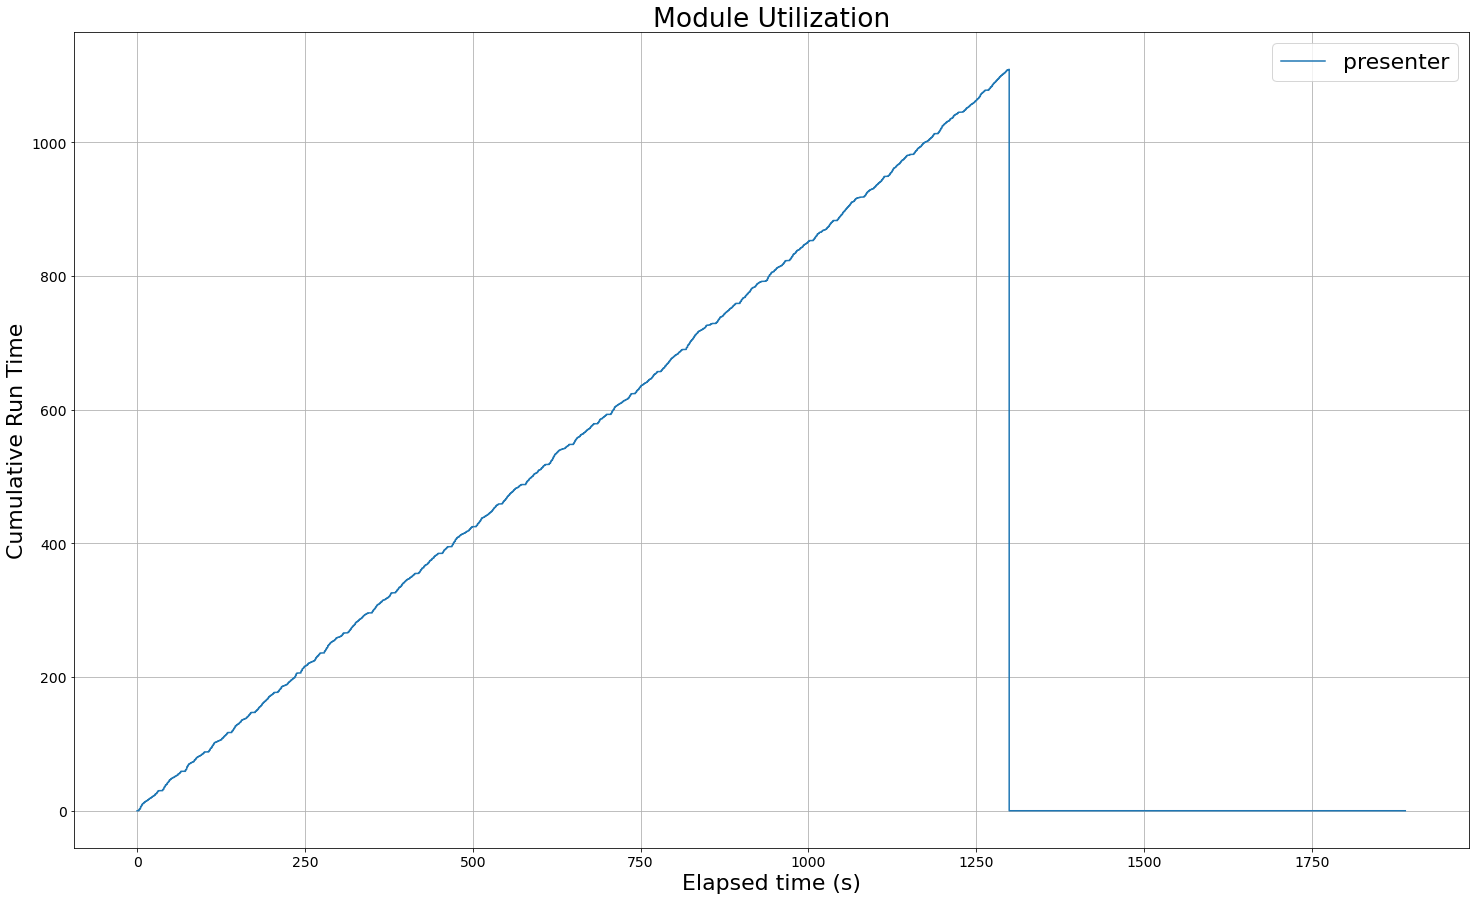

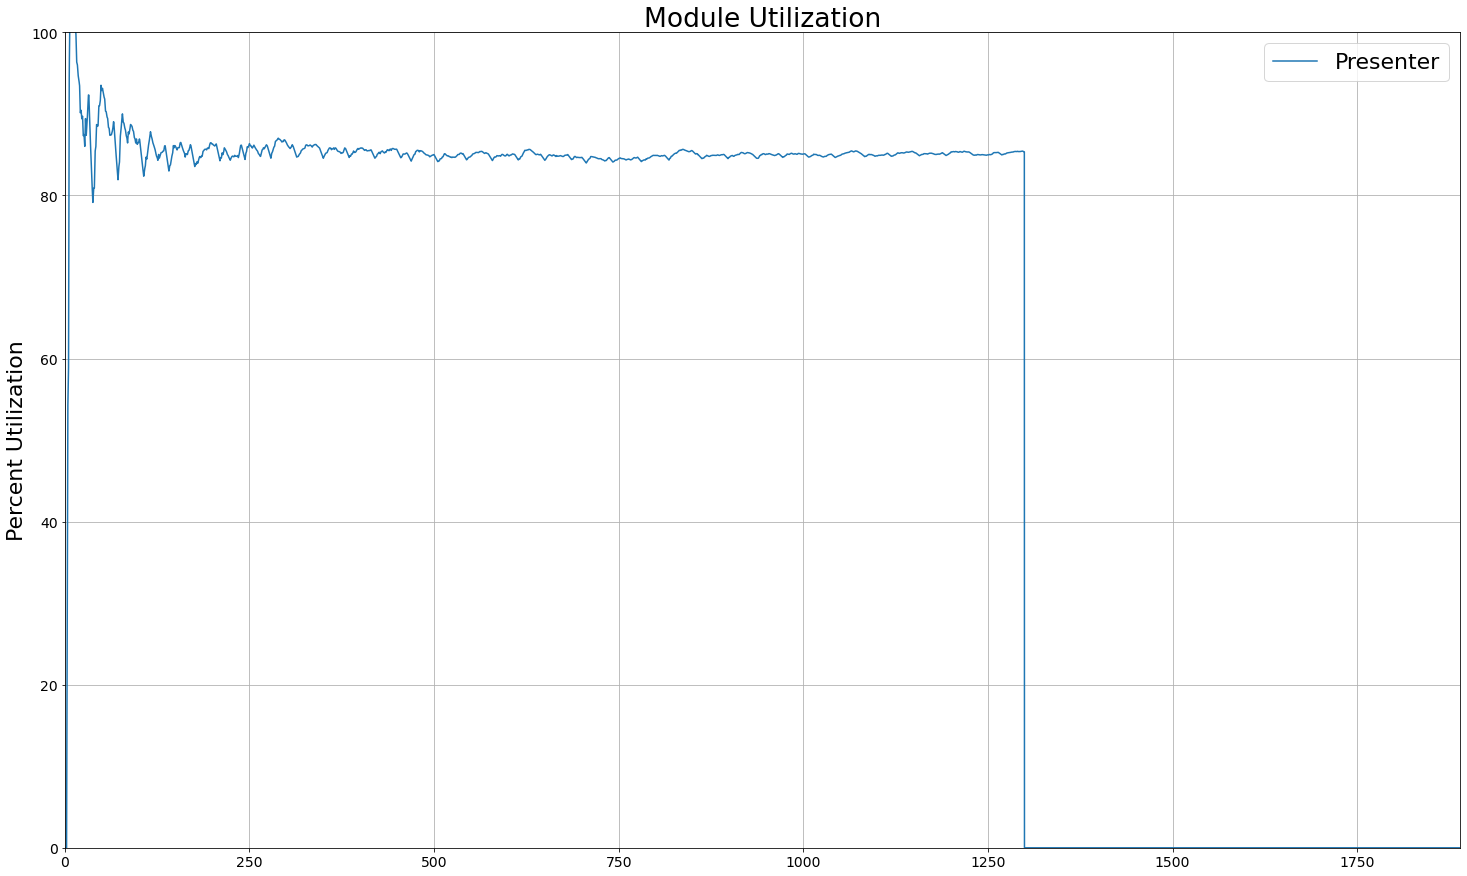

In [19]:
##Presenter utilization summary

print("Presenter Median Percent Utilization")
print(round(np.nanmedian(present_ult_timeseries_percent)))
summary["Presenter Percent Utilization"] = []
summary["Presenter Percent Utilization"].append(round(np.nanmedian(present_ult_timeseries_percent),2))
# summary["Presenter Percent Utilization"].append(round(np.nanstd(present_ult_timeseries_percent),2))
summary["Presenter Percent Utilization"].append(np.NaN)
summary["Presenter Percent Utilization"].append(round(np.nanmax(present_ult_timeseries_percent),2))
# summary["Presenter Percent Utilization"].append(round(np.nanmin(present_ult_timeseries_percent),2))

figure(7)
plot(test_data['ElapsedTime'],present_ult_timeseries, label='presenter')
title('Module Utilization')
xlabel('Elapsed time (s)')
ylabel('Cumulative Run Time')
# xlim(0,100)
# ylim(0,100)
legend()
grid(True)

figure(8)
plot(elapsed_time_corrected,present_ult_timeseries_percent, label='Presenter')
title('Module Utilization')
ylabel('Percent Utilization')
legend()
ylim(0,100)
xlim(0,max(test_data['ElapsedTime']))
grid(True)

# figure()
# plot(test_data['ElapsedTime'],present_sliding, label='presenter')
# title('Module Utilization')
# xlabel('Elapsed time (s)')
# ylabel('Cumulative Run Time')
# # xlim(0,100)
# legend()
# grid(True)

In [20]:
##This cell combines the presenter utilization with the lane switch presenter utilization
#See the throughput presentation for an explanation for this.

indexin = []
indexout = [] 
adwda = [0]
lsp_time_cumsum = adwda + list(np.cumsum(LS2PM_time))
print(lsp_time_cumsum, len(lsp_time_cumsum))
flag=False
cnt = 0 
lsp_ult_timeseries = []

# print(pre_time_cumsum[cnt+1]) 
for l in test_data.index:
#     l = str(l)
    if (str(test_data['Title'][l]).find('IOModuleDriver[Transfer].TransferPresenterCmd - [TransferPresenterMode: FromLaneSwitchPresenterToPresenter; ]') != -1):
        indexin.append(l)

    if (str(test_data['Title'][l]).find('IOModuleDriver[Transfer].TransferPresenterRsp - [TransferPresenterMode: FromLaneSwitchPresenterToPresenter; ]') != -1):
        indexout.append(l)
                
for l in test_data.index:
    if (str(test_data['Title'][l]).find('IOModuleDriver[Transfer].TransferPresenterCmd - [TransferPresenterMode: FromLaneSwitchPresenterToPresenter; ]') != -1):
        cnt += 1
        flag = True

    if (str(test_data['Title'][l]).find('IOModuleDriver[Transfer].TransferPresenterRsp - [TransferPresenterMode: FromLaneSwitchPresenterToPresenter; ]') != -1):
        flag = False   
        
#  and (cnt<len(indexin))
    if flag == False and (cnt < len(lsp_time_cumsum) - 1):
        lsp_ult_timeseries.append(lsp_time_cumsum[cnt])
#         print(present_ult_timeseries)
    elif flag == True and (cnt < len(lsp_time_cumsum) - 1):
#         print(cnt)
#         print(l)
#         print(indexin)
        lsp_ult_timeseries.append(((lsp_time_cumsum[cnt]-lsp_time_cumsum[cnt-1])/(indexout[cnt-1]-indexin[cnt-1]))*(l-indexin[cnt-1])+lsp_time_cumsum[cnt-1])
#     elif (cnt == ((len(lsp_time_cumsum)) - 1)):
    else:
        lsp_ult_timeseries.append(0)

# print(len(pre_time_cumsum))
# print(cnt)

elapsed_time_corrected = []
cnt=0
for n in range(0,len(test_data['ElapsedTime'])-1):
    if test_data['ElapsedTime'][test_data.index[n+1]] == test_data['ElapsedTime'][test_data.index[n]]:
        cnt+=1
    else: 
        elapsed_time_corrected = elapsed_time_corrected + list(np.linspace(test_data['ElapsedTime'][test_data.index[n-cnt]],test_data['ElapsedTime'][test_data.index[n+1]],cnt+2)[0:-1])
        cnt=0
if len(elapsed_time_corrected) < len(lsp_ult_timeseries):
    elapsed_time_corrected = elapsed_time_corrected + list(np.ones(len(present_ult_timeseries)-len(elapsed_time_corrected))*max(test_data['ElapsedTime']))
    
lsp_ult_timeseries_percent = np.true_divide(lsp_ult_timeseries,elapsed_time_corrected)*100

figure()
plot(test_data['ElapsedTime'],lsp_ult_timeseries, label='LSP')
title('Module Utilization')
xlabel('Elapsed time (s)')
ylabel('Cumulative Run Time')
# xlim(0,100)
# ylim(0,100)
legend()
grid(True)

figure(13)
plot(elapsed_time_corrected,lsp_ult_timeseries_percent, label='LSP')
plot(elapsed_time_corrected,present_ult_timeseries_percent, color = 'red', label='Presenter')
plot(elapsed_time_corrected,present_ult_timeseries_percent+lsp_ult_timeseries_percent, color='black', label='Presenter+LSP')
title('Module Utilization')
ylabel('Percent Utilization')
legend()
ylim(0,100)
xlim(0,max(test_data['ElapsedTime']))
grid(True)

savefig(f"PresenterBottleneck{analyzercnt} Analyzer_{test_type}.png")
# if save_figs == True:
#     savefig(f"PresenterBottleneck{analyzercnt} Analyzer_{test_type}.png")

NameError: name 'LS2PM_time' is not defined

In [21]:
##Buffer position handling for buffer utilization analysis
#performs a utilization analysis for the buffer by keeping track of which positions are filled.
#Buffer positions are assigned their own individual name. I store into the slot and out of the slot messages
#for each position, by position, and leverage this to determine the utilization. 
#Essentially I count the number of buffer positions which are filled across the time vector of the experiment

buffernames = ['RightBuffer0','RightBuffer1','RightBuffer2','RightBuffer3','RightBuffer4','RightBuffer5','RightBuffer6','RightBuffer7','RightBuffer8','RightBuffer9','RightBuffer10','RightBuffer11','RightBuffer12','RightBuffer13','RightBuffer14','RightBuffer15','RightBuffer16','RightBuffer17','RightBuffer18','RightBuffer19', \
                'LeftBuffer0','LeftBuffer1','LeftBuffer2','LeftBuffer3','LeftBuffer4','LeftBuffer5','LeftBuffer6','LeftBuffer7','LeftBuffer8','LeftBuffer9','LeftBuffer10','LeftBuffer11','LeftBuffer12','LeftBuffer13','LeftBuffer14','LeftBuffer15','LeftBuffer16','LeftBuffer17','LeftBuffer18','LeftBuffer19']

posdict = {}
d = {'In':[],'Out':[]}
posdict = {i: {'In':[],'Out':[]} for i in buffernames}

for bps in buffernames: #loops over buffer names
    indexin = []
    indexout = []
    for l in test_data['Title']: #loops over messages
        l = str(l) #converts to strings just in case
        if (l.find('Destination: '+str(bps)) != -1) and (l.find('TransferDistributorRsp') != -1): #store index of message, l, if the message is response message to dropping a rack off at a destination (at the buffer position bps)
            indexin.append(True)
        else:
            indexin.append(False)
        if (l.find('Source: '+str(bps)) != -1) and (l.find('TransferDistributorRsp') != -1): #store the index of message, l, if the message is response message of finishing picking up a rack from the source (the buffer position bps)
            indexout.append(True)
        else:
            indexout.append(False)
        
    posdict[bps]['Inlocs'] = indexin
    posdict[bps]['Outlocs'] = indexout
    posdict[bps]['In'] = (test_data.loc[indexin].ElapsedTime.to_list())
    posdict[bps]['Out'] = (test_data.loc[indexout].ElapsedTime.to_list())

#buffer count and buffer fill percentage over time 
bfrcnt = []
bfrpcnt = []
for i in test_data['ElapsedTime']:
    poscnt = 0 #for each i (time) set position count to zero
    for p in buffernames: #loop over buffer position names
        if len(posdict[p]['In']) == len(posdict[p]['Out']): #check 
            for j in range(len(posdict[p]['In'])):
                if (posdict[p]['In'][j] <= i) and (i <= posdict[p]['Out'][j]):
                    poscnt += 1
    bfrcnt.append(poscnt)
    bfrpcnt.append(poscnt/32*100)

In [23]:
#Printing of summary data

print('\nDistributor Total Run Time')
print(distributor_time_sum, 'seconds')

print('\nDistributor Utilization as percent of total run time')
print(distributor_util, '%')

print('\nLane Switch 1 Total Run Time')
print(lane_switch_1_time, 'seconds')

print('\nLane Switch 1 Utilization as percent of total run time')
print(lane_switch_1_util, '%')

for N in range(1,7,1):
    if f"Analyzer {N} Input" in AIU_time_sum.keys():
        print(f'\nAnalyzer {N} Input Total Usage Time')
        print(AIU_time_sum[f"Analyzer {N} Input"], 'seconds')

        print(f'\nAnalyzer {N} Input Utilization as percent of total run time')
        print(AIU_util[f"Analyzer {N} Input"], '%')

print('\nPresenter Total Usage Time')
print(pre_time_sum, 'seconds')

print('\nPresenter Utilization as percent of total run time')
print(pre_util, '%')


Distributor Total Run Time
749.0 seconds

Distributor Utilization as percent of total run time
39.65 %

Lane Switch 1 Total Run Time
208.0 seconds

Lane Switch 1 Utilization as percent of total run time
0.11 %

Analyzer 1 Input Total Usage Time
457.0 seconds

Analyzer 1 Input Utilization as percent of total run time
24.19 %

Analyzer 2 Input Total Usage Time
239.0 seconds

Analyzer 2 Input Utilization as percent of total run time
12.65 %

Analyzer 3 Input Total Usage Time
197.0 seconds

Analyzer 3 Input Utilization as percent of total run time
10.43 %

Analyzer 4 Input Total Usage Time
333.0 seconds

Analyzer 4 Input Utilization as percent of total run time
17.63 %

Analyzer 5 Input Total Usage Time
122.0 seconds

Analyzer 5 Input Utilization as percent of total run time
6.46 %

Analyzer 6 Input Total Usage Time
44.0 seconds

Analyzer 6 Input Utilization as percent of total run time
2.33 %

Presenter Total Usage Time
1109.0 seconds

Presenter Utilization as percent of total run time
5

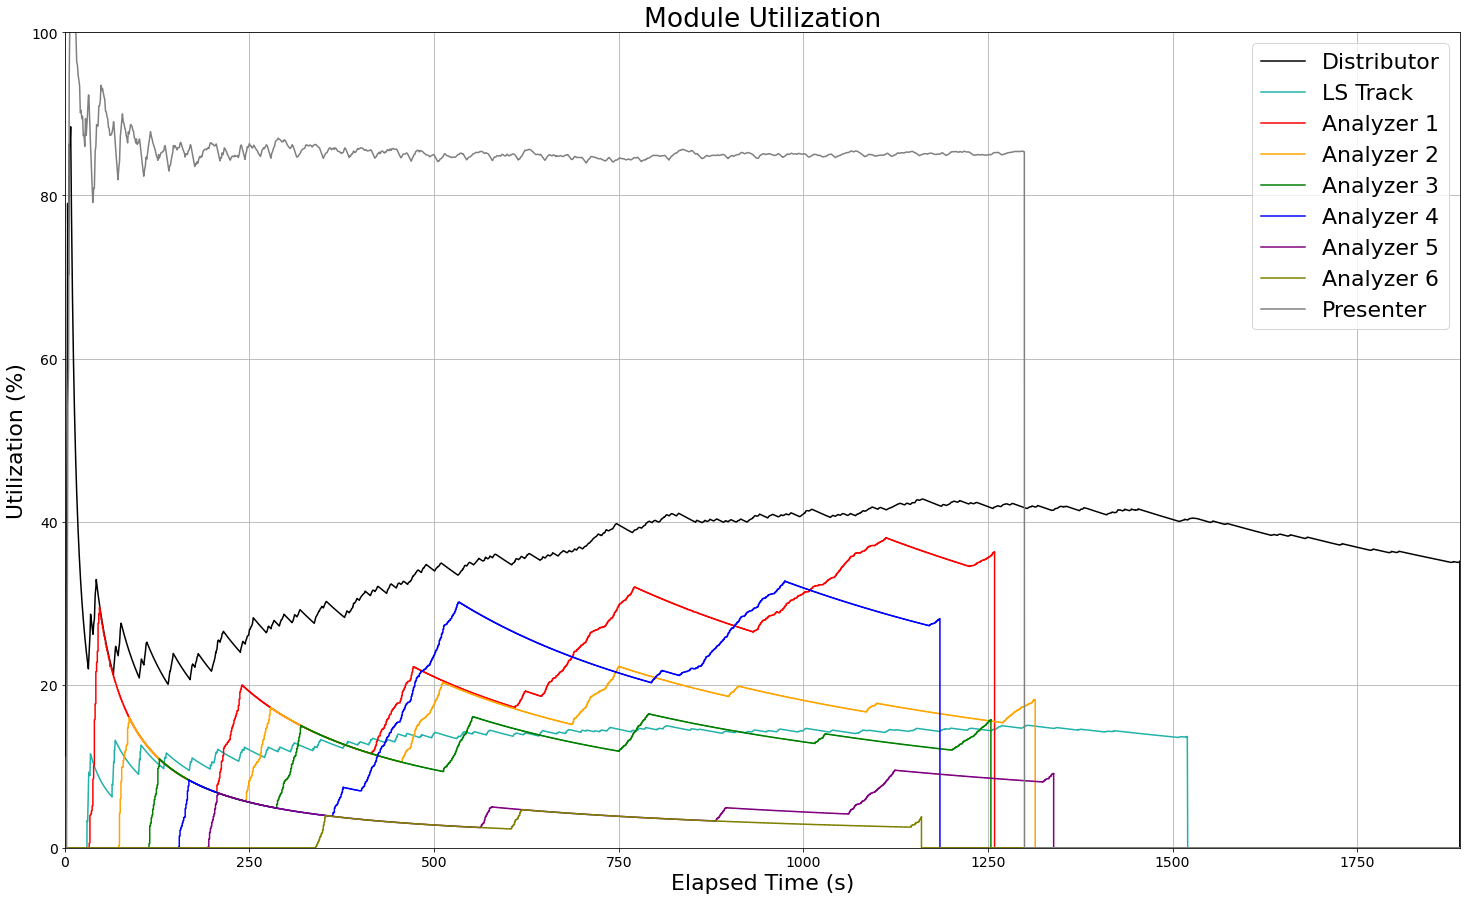

In [24]:
#Summary Figure which incorporates all the utilization into one figure and presents them using the colors declared at the beginning of the program with the variable "color"

figure(9)
plot(elapsed_time_corrected,dist_ult_timeseries_percent, label='Distributor', c=colors['Distributor'])
plot(elapsed_time_corrected,lst_ult_timeseries_percent, label='LS Track', c = colors['LS Track'])
for N in range(1,7,1):
    if Analyzer_used[f"Analyzer {N}"] == True:
        plot(test_data['ElapsedTime'],AIU_ult_timeseries_percent[f"Analyzer {N}"], label=f'Analyzer {N}', c=colors[f"Analyzer {N}"])
plot(elapsed_time_corrected,present_ult_timeseries_percent, label='Presenter', c = colors['Presenter'])
title('Module Utilization')
xlabel('Elapsed Time (s)')
ylabel('Utilization (%)')
legend()
ylim(0,100)
xlim(0,max(elapsed_time_corrected))
grid(True)

if save_figs == True:
    savefig(f"ModuleUtilization_{analyzercnt} Analyzer_{test_type}.png")

['Analyzer 1', 'Analyzer 2', 'Analyzer 3', 'Analyzer 4', 'Analyzer 5', 'Analyzer 6']


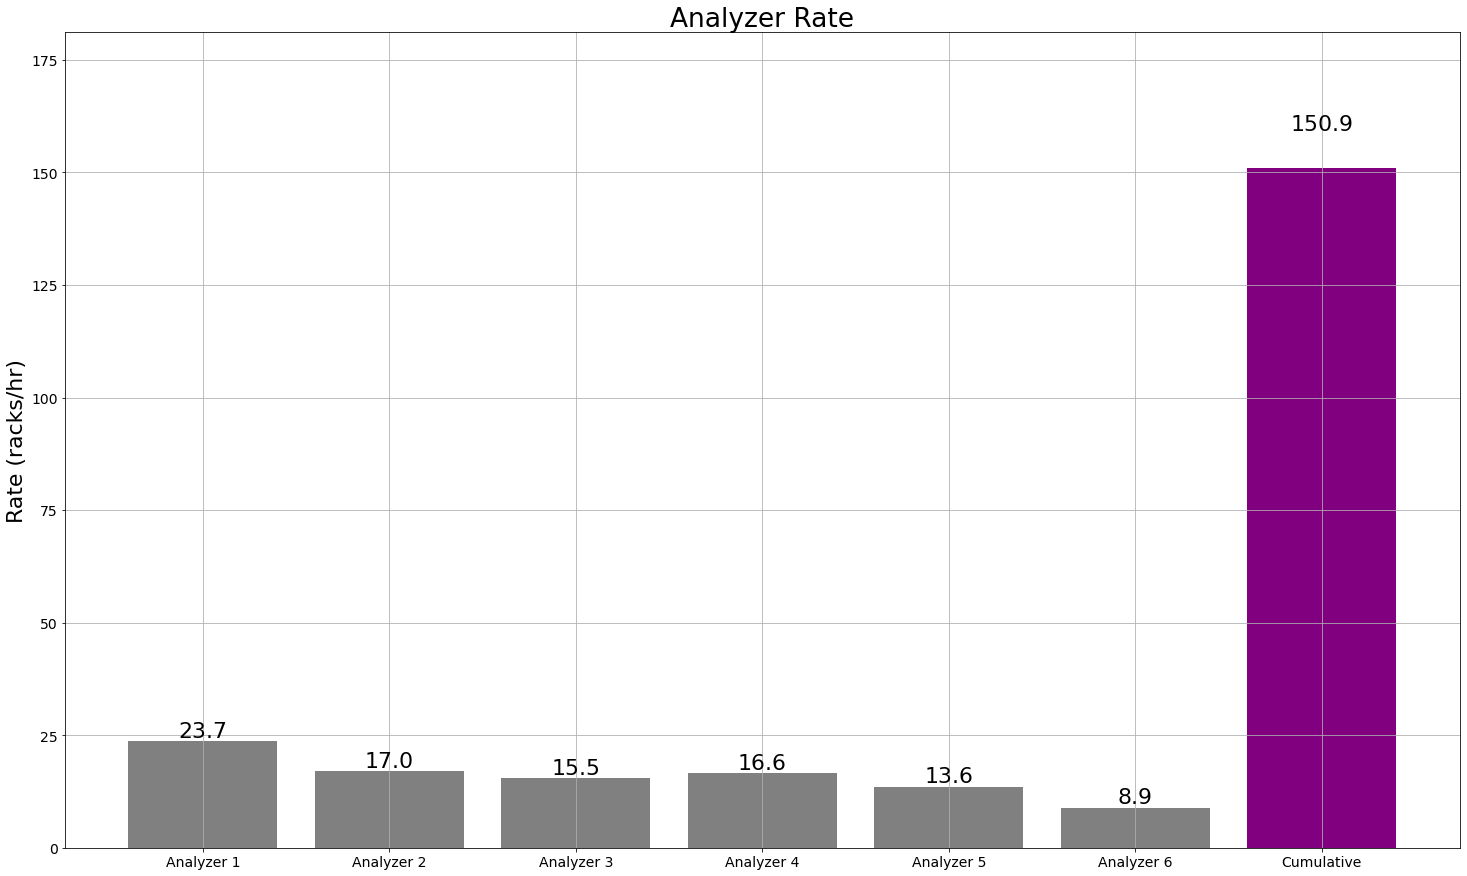

In [25]:
#Creation of a bar chart to present analyzer throughput
#does allow for incorporation of analyzer throughput variation however I haven't come up with a good way to do that

ARRT_stds = [0 if i > 2*np.nanmax(ARRT_means_lst) else i for i in ARRT_stds]
print(ART_names)
##yerr = ART_stds use #use in barplot call to add error bars currently the computation of the stdev makes no sense so excluded
include_error = False 
figure(10)
# barplot1 = bar(ART_names,ARRT_means_lst, capsize = 5, color = 'gray')
if include_error == True:
    barplot1 = bar(ART_names,ARRT_means_lst, yerr = ART_stds, capsize = 5, color = 'gray')
else:
    barplot1 = bar(ART_names,ARRT_means_lst, capsize = 5, color = 'gray')
barplot2 = bar("Cumulative", cum_rate, color='Purple')
grid(True)
ylim(0,cum_rate*1.20)
title('Analyzer Rate')
ylabel('Rate (racks/hr)')

def autolabel(rects,bar_plot,bar_label, include_error):
    for idx,rect in enumerate(bar_plot):
        height = rect.get_height()
        if (Analyzer_used[f"Analyzer {idx+1}"] == True) and include_error == True:
            text(rect.get_x() + rect.get_width()/2., 1.05*height+ART_stds[idx],
                    round(bar_label[idx],1),
                    ha='center', va='bottom', rotation=0)
        elif (Analyzer_used[f"Analyzer {idx+1}"] == True):
            text(rect.get_x() + rect.get_width()/2., height,
                    round(bar_label[idx],1),
                    ha='center', va='bottom', rotation=0)
def autolabel1(rects,bar_plot,bar_label):
    for idx,rect in enumerate(bar_plot):
        height = rect.get_height()
        text(rect.get_x() + rect.get_width()/2., 1.05*height,
                round(bar_label,1),
                ha='center', va='bottom', rotation=0)
        
autolabel(barplot1,barplot1,ARRT_means_lst,include_error)
autolabel1(barplot2,barplot2,cum_rate)

if save_figs == True:
    savefig(f"RackRate_{analyzercnt} Analyzer_{test_type}.png")

Median Buffer Percentage
28


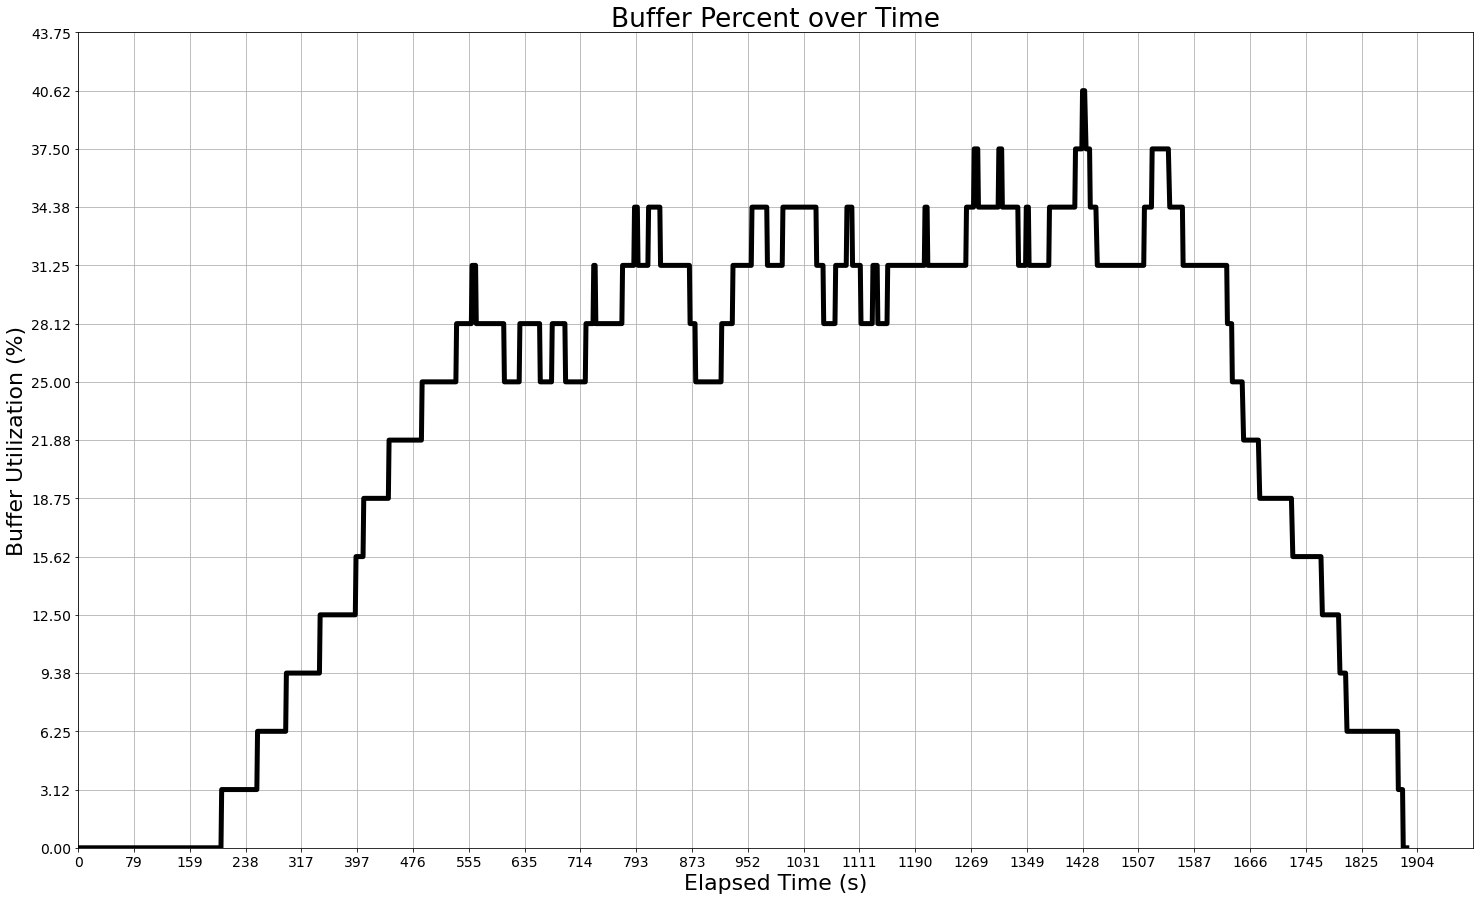

In [26]:
# Buffer count figure

print("Median Buffer Percentage")
print(round(np.nanmedian(bfrpcnt)))

summary["Buffer Percent Utilization"] = []
summary["Buffer Percent Utilization"].append(round(np.nanmedian(bfrpcnt),2))
# summary["Presenter Percent Utilization"].append(round(np.nanstd(present_ult_timeseries_percent),2))
summary["Buffer Percent Utilization"].append(np.NaN)
summary["Buffer Percent Utilization"].append(round(np.nanmax(bfrpcnt),2))

figure(11)
plot(test_data['ElapsedTime'],bfrpcnt, c = 'k' , linewidth = 5)
title('Buffer Percent over Time')
xlabel('Elapsed Time (s)')
ylabel('Buffer Utilization (%)')
xlim(0,run_time*1.05)
xticks(np.arange(0,run_time*1.05,(run_time*1.05)/25))
yticks(np.arange(0,max(bfrpcnt)+4/32*100,1/32*100))
ylim(0,max(bfrpcnt)+1/32*100)
grid(True)

if save_figs == True:
    savefig(f"BufferUtilization_{analyzercnt} Analyzer_{test_type}.png")

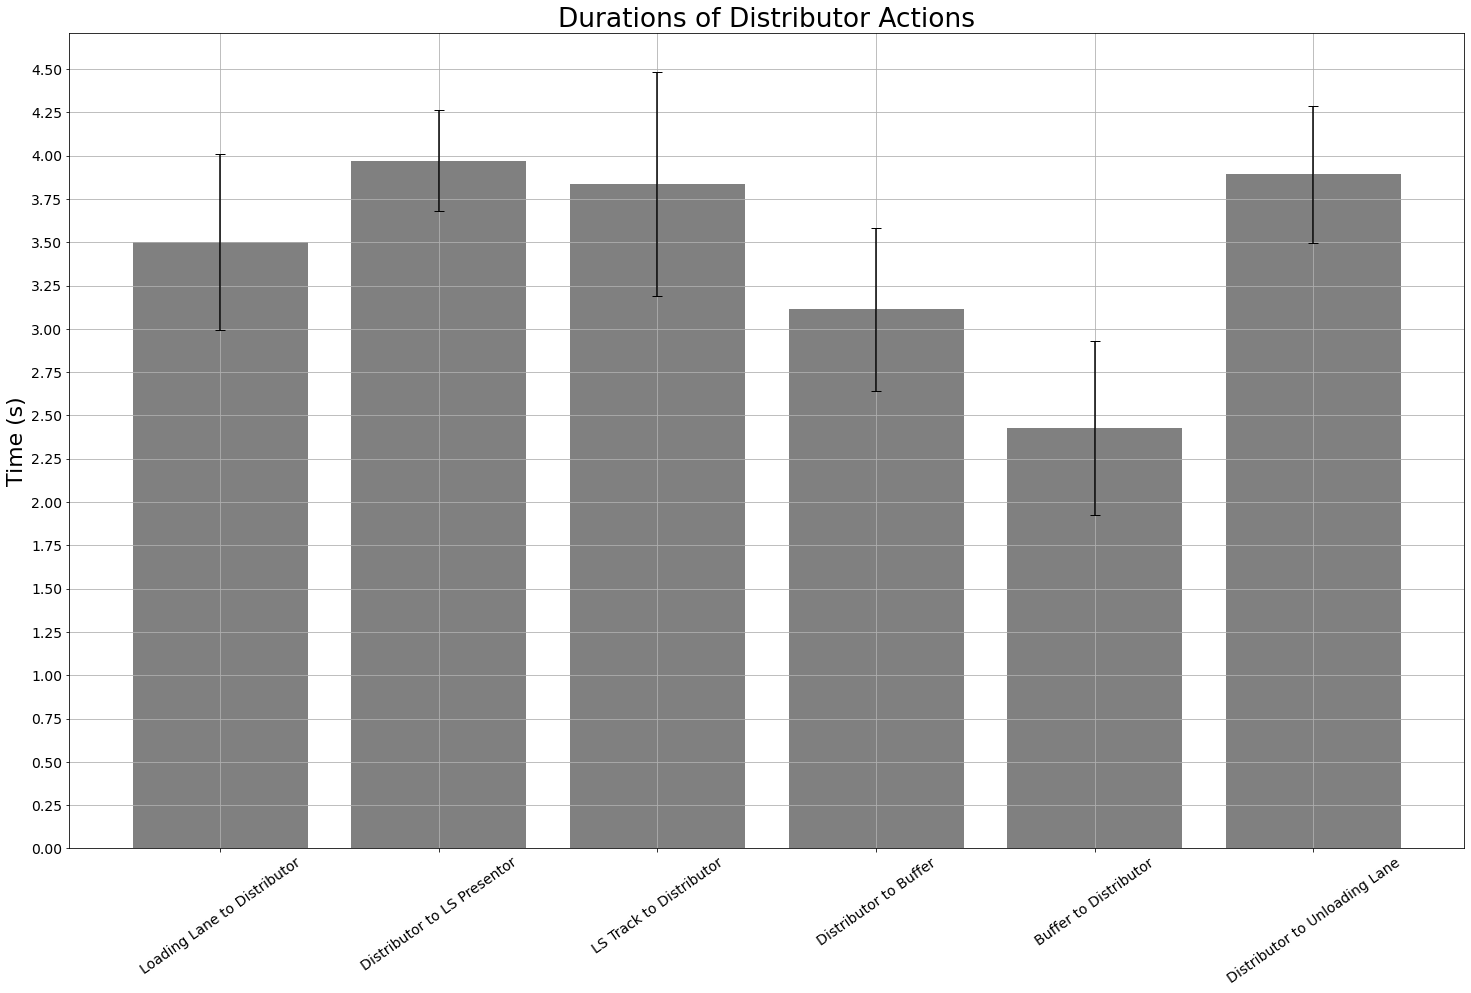

In [27]:
## Distributor Actions Figure

names = ['Loading Lane to Distributor', 'Distributor to LS Presentor', 'LS Track to Distributor', 'Distributor to Buffer', 'Buffer to Distributor', 'Distributor to Unloading Lane' ]
x_pos = np.arange(len(names))
distributor_means = [R2D_stats[2], D2LS_stats[2], LST2D_stats[2], D2B_stats[2], B2D_stats[2], D2UL_stats[2]]
distributor_std = [np.sqrt(R2D_stats[3]), np.sqrt(D2LS_stats[3]), np.sqrt(LST2D_stats[3]), np.sqrt(D2B_stats[3]), np.sqrt(B2D_stats[3]), np.sqrt(D2UL_stats[3])]

figure(12)

bars = bar(x_pos, distributor_means, yerr = distributor_std, capsize = 5, color = 'gray')
# error_kw = {'label': ['%.2f' % e for e in distributor_std]}
# bar_label(bars, labels = ['%.2f' % e for e in distributor_std])
ylabel('Time (s)')
xticks(x_pos, labels = names, rotation = 35)
yticks(np.arange(0,math.ceil(max(distributor_means))+1.1*max(distributor_std),0.25))
title('Durations of Distributor Actions')
# legend()
grid(True)

if save_figs == True:
    savefig(f"DistributorActions_{analyzercnt} Analyzer_{test_type}.png")

In [28]:
#Printing of Summary variable and saving of it as a csv file

print(summary)

summary_df = pd.DataFrame.from_dict(summary, orient = 'index', columns=['Value','Std','Max'])
summary_df.to_csv(f"Summary_{analyzercnt} Analyzer_{test_type}.csv")

summary_df

{'Distributor Percent Utilization': [38.86, nan, 88.42], 'LS Track Percent Utilization': [14.19, nan, 15.04], 'Analyzer 1 Percent Utilization': [19.99, nan, 38.02], 'Analyzer 2 Percent Utilization': [16.5, nan, 22.25], 'Analyzer 3 Percent Utilization': [12.57, nan, 16.43], 'Analyzer 4 Percent Utilization': [20.84, nan, 32.7], 'Analyzer 5 Percent Utilization': [4.17, nan, 9.51], 'Analyzer 6 Percent Utilization': [2.63, nan, 4.68], 'Analyzer 1 Rate': [25.62, nan, nan], 'Analyzer 2 Rate': [24.71, nan, nan], 'Analyzer 3 Rate': [25.68, nan, nan], 'Analyzer 4 Rate': [24.22, nan, nan], 'Analyzer 5 Rate': [25.03, nan, nan], 'Analyzer 6 Rate': [25.65, nan, nan], 'Cumulative Rate': [150.92, nan, nan], 'Presenter Percent Utilization': [84.98, nan, 118.95], 'Buffer Percent Utilization': [28.12, nan, 40.62]}


,Value,Std,Max
Distributor Percent Utilization,38.86,NaN,88.42
LS Track Percent Utilization,14.19,NaN,15.04
Analyzer 1 Percent Utilization,19.99,NaN,38.02
Analyzer 2 Percent Utilization,16.50,NaN,22.25
Analyzer 3 Percent Utilization,12.57,NaN,16.43
Analyzer 4 Percent Utilization,20.84,NaN,32.70
Analyzer 5 Percent Utilization,4.17,NaN,9.51
Analyzer 6 Percent Utilization,2.63,NaN,4.68
Analyzer 1 Rate,25.62,NaN,NaN
Analyzer 2 Rate,24.71,NaN,NaN


In [29]:
# temp = []
# for i in range(len(j)):
#     if ((j.Timestamp[i+1]) == j[i]+2) and (i<len(j)):
#         temp.append(j.Watchname)
#     else:
#         temp.append(np.Nan)
        
        
# 1. dataframe.Timestamp[0]      2. dataframe['Timestamp'][0]

# dataframe.keys() --> [key1 key2 key3...]

# for keylist in dataframe.keys():
#     dataframe[keys]